# Opdracht 2: Voorspel verhuuraantallen


Gemaakt door:

- Sami "Sami" latic 
- Daan "Daan Eising" Eising
- Mark "Markolie20" Olieman
- Jesse "zdfgdfsg" van der Westen

# Inhoudsopgave
H1: Importeren van data en libraries

H2: Exploratory Data Analysis

- H2.2: Data klaar maken voor EDA

- H2.3: EDA bevindingen

- H2.4: Timeseries analyse

H3: Time series feature engineering

H4: Modelleren

H5: Bevindingen

H6: Conclusie & aanbevelingen

H7: Bronvermelding

# Hoofdstuk 1: Importeren van data en libraries

In [46]:
%reset
import warnings

import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, log_loss
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf

from pmdarima import auto_arima

from math import sqrt

from prophet import Prophet

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [47]:
sns.set_theme()

In [48]:
df = pd.read_csv("data/train.csv")
display(df)

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163


# Hoofdstuk 2: Exploratory Data Analysis

## Hoofdstuk 2.1: Data klaar maken voor EDA

In [49]:
df['date_hour'] = pd.to_datetime(df['date_hour'])

def datetime_preprocessing(df):
    """
    Adds columns based on time to the pandas dataframe, the following columns will be added: hour, dayofweek, dayofyear,
    weekday_name, week_number, month, month_name, year and season
    
    Parameters:
    df: Pandas Dataframe which has a time series
    """
    df['hour'] = df['date_hour'].dt.hour
    df['dayofweek'] = df['date_hour'].dt.dayofweek
    df['dayofyear'] = df['date_hour'].dt.dayofyear
    df['weekday_name'] = df['date_hour'].dt.day_name()
    df['week_number'] = df['date_hour'].dt.isocalendar().week
    df['month'] = df['date_hour'].dt.month
    df['month_name'] = df['date_hour'].dt.month_name()
    df['year'] = df['date_hour'].dt.year
    season2011 = pd.cut(df['dayofyear'][df['year'] == 2011], bins=[0, 59, 151, 243, 334, 365], labels=['winter', 'spring', 'summer', 'fall', 'winter'], ordered=False)
    season2012 = pd.cut(df['dayofyear'][df['year'] == 2012], bins=[0, 60, 152, 244, 335, 366], labels=['winter', 'spring', 'summer', 'fall', 'winter'], ordered=False)
    df['season'] = season2011.tolist() + season2012.tolist()
    
    return df

df = datetime_preprocessing(df)
display(df[45:])

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour,dayofweek,dayofyear,weekday_name,week_number,month,month_name,year,season
45,2011-01-02 22:00:00,0,1,0.24,0.2121,0.44,0.2985,9,22,6,2,Sunday,52,1,January,2011,winter
46,2011-01-02 23:00:00,0,1,0.22,0.2273,0.47,0.1642,8,23,6,2,Sunday,52,1,January,2011,winter
47,2011-01-03 00:00:00,0,1,0.22,0.1970,0.44,0.3582,5,0,0,3,Monday,1,1,January,2011,winter
48,2011-01-03 01:00:00,0,1,0.20,0.1667,0.44,0.4179,2,1,0,3,Monday,1,1,January,2011,winter
49,2011-01-03 04:00:00,0,1,0.16,0.1364,0.47,0.3881,1,4,0,3,Monday,1,1,January,2011,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,19,4,335,Friday,48,11,November,2012,fall
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,20,4,335,Friday,48,11,November,2012,fall
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,21,4,335,Friday,48,11,November,2012,fall
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163,22,4,335,Friday,48,11,November,2012,fall


## Hoofdstuk 2.2: EDA visualisaties

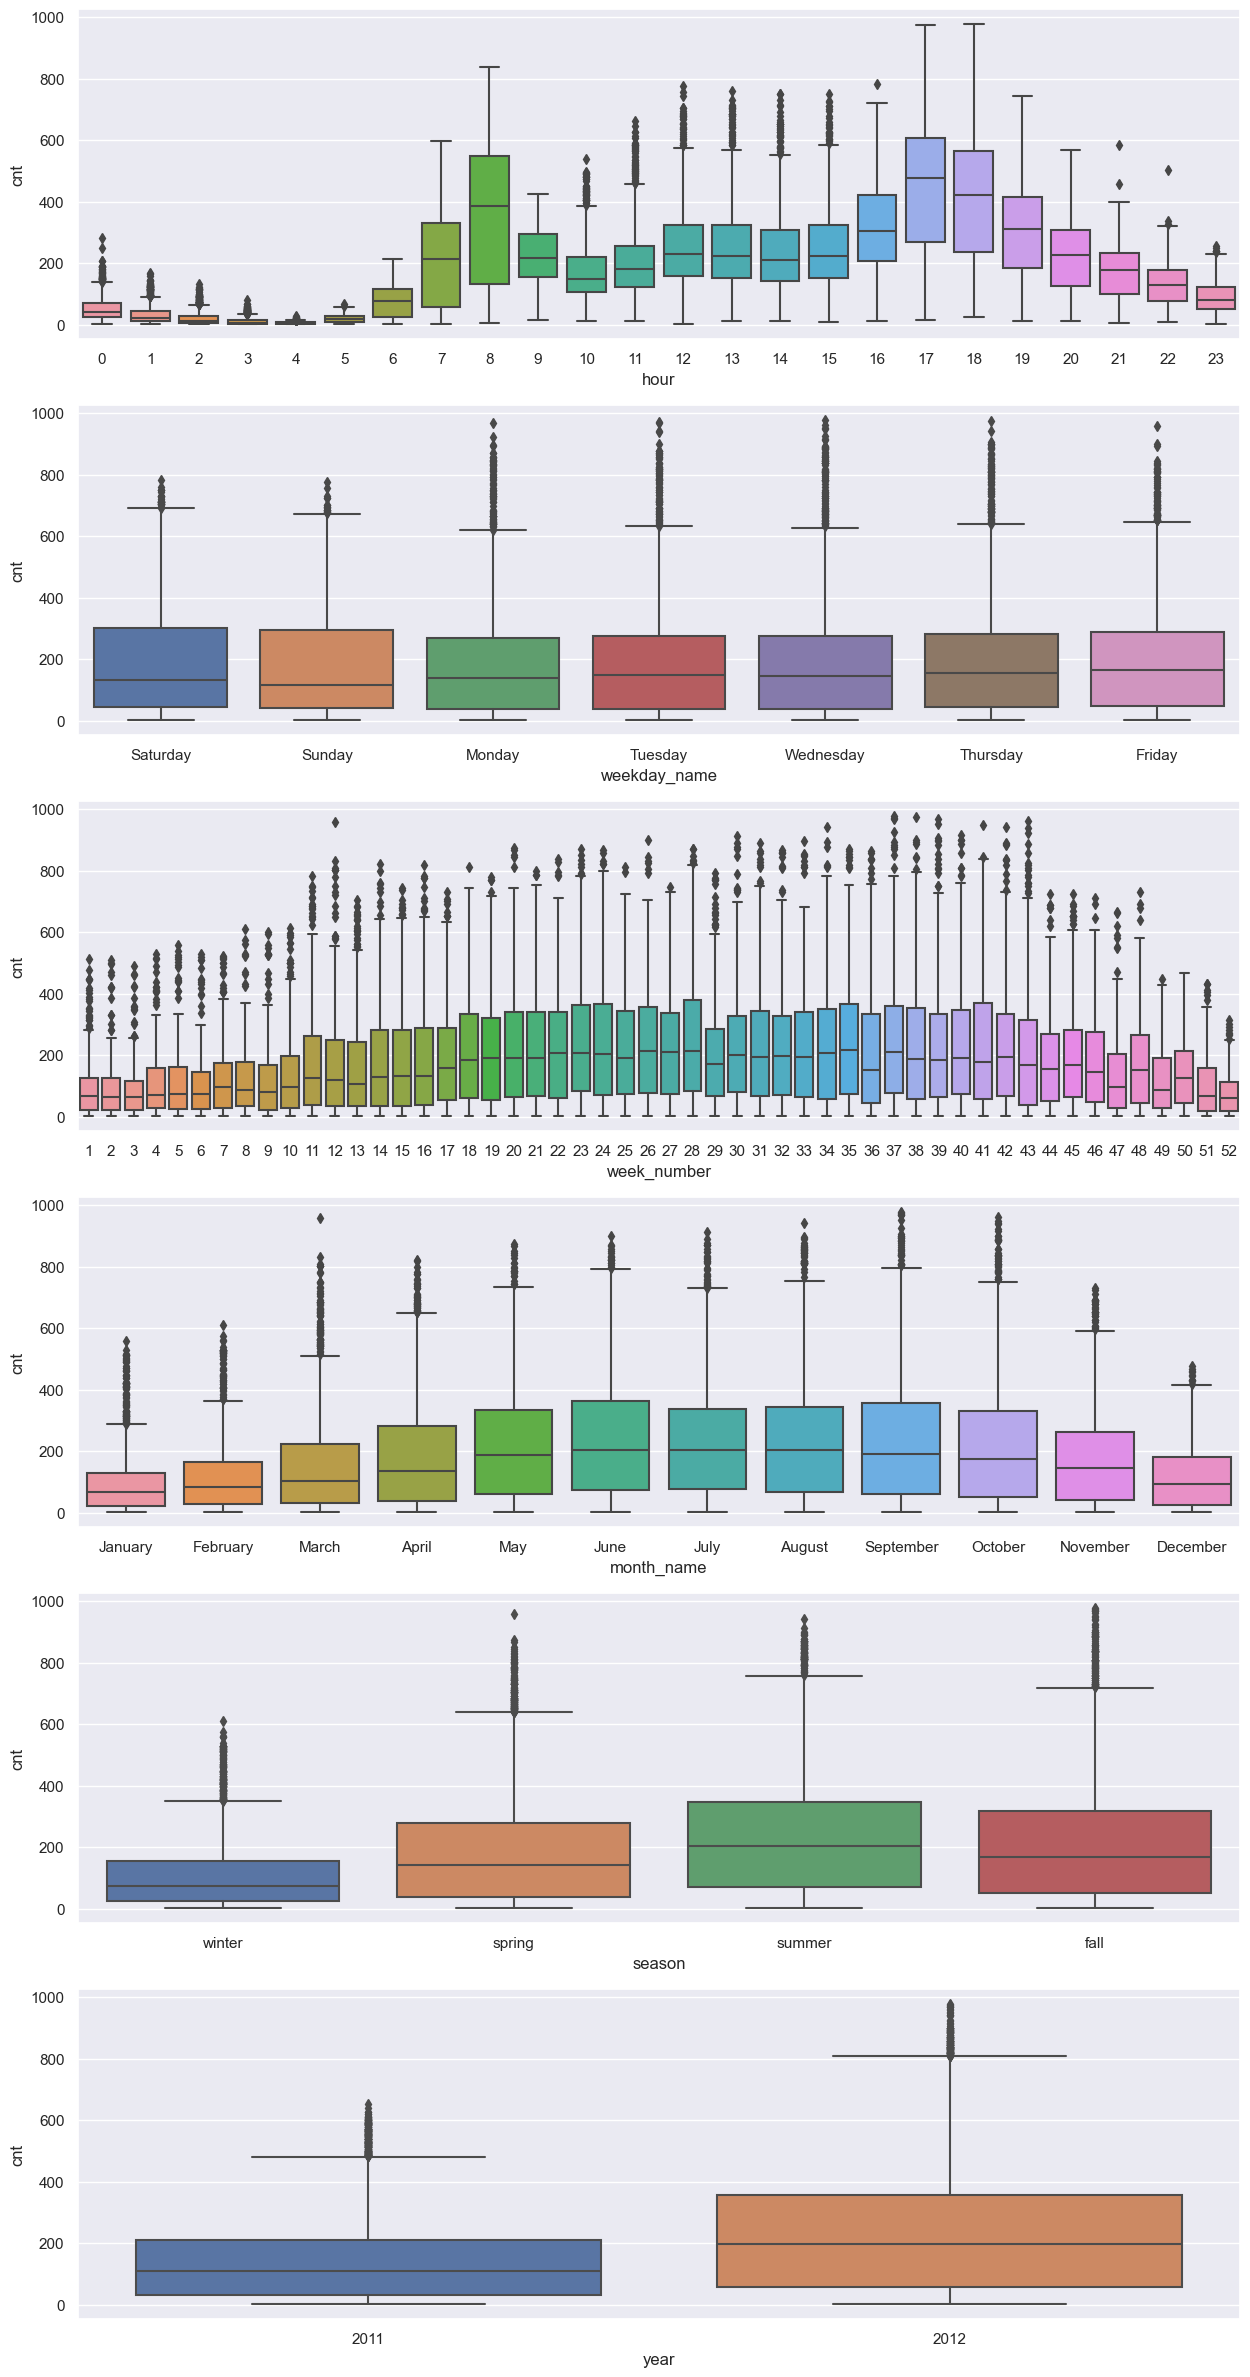

In [50]:
warnings.filterwarnings('ignore')
def plot_boxes(df):
    """
    Plot boxplots of time series in hours, days, weeks, months, seasons and years
    
    Parameters:
    -df: pandas DataFrame which has the target column: cnt, and the following time columns: hour, weekday_name, week_number, 
         month_name, season and year
    """
    fig, axes = plt.subplots(6, 1, figsize=(15, 30))
    sns.boxplot(data=df, x='hour', y='cnt', ax=axes[0])
    sns.boxplot(data=df, x='weekday_name', y='cnt', ax=axes[1])
    sns.boxplot(data=df, x='week_number', y='cnt', ax=axes[2])
    sns.boxplot(data=df, x='month_name', y='cnt', ax=axes[3])
    sns.boxplot(data=df, x='season', y='cnt', ax=axes[4])
    sns.boxplot(data=df, x='year', y='cnt', ax=axes[5])
    
plot_boxes(df)

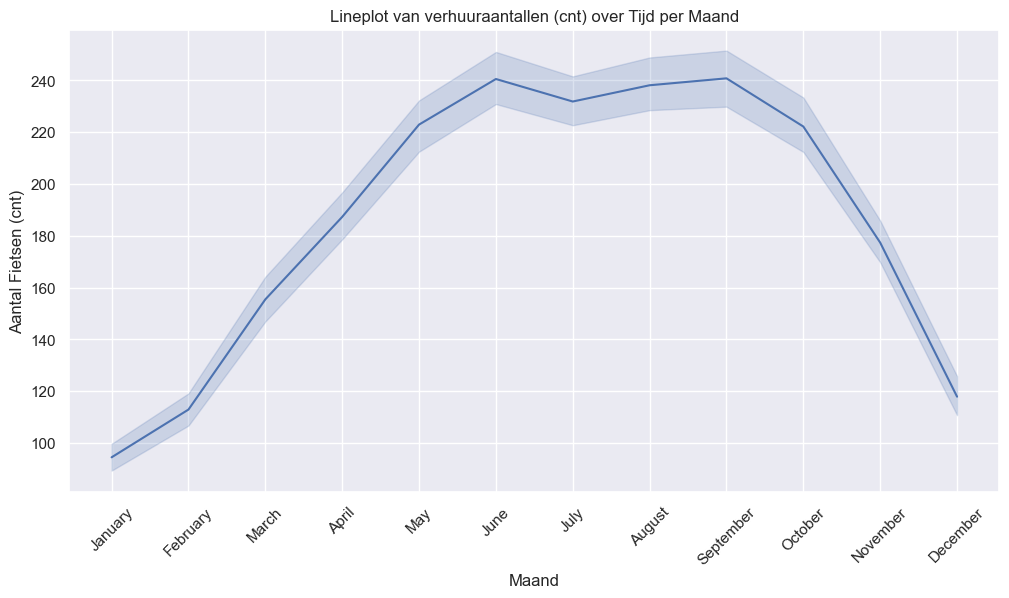

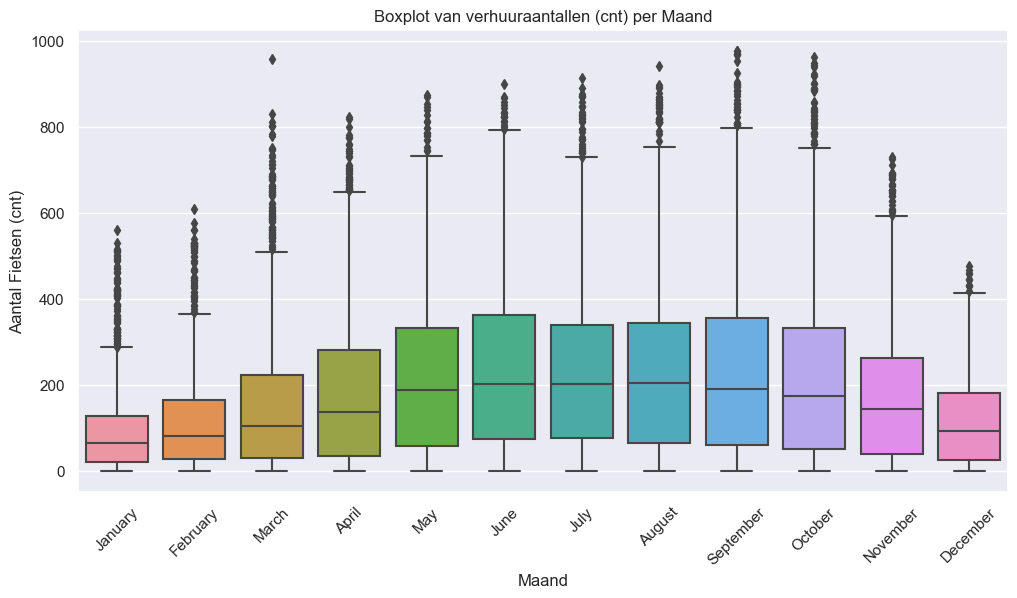

In [51]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(12, 6))
sns.lineplot(x=df['date_hour'].dt.strftime('%B'), y='cnt', data=df)
plt.title('Lineplot van verhuuraantallen (cnt) over Tijd per Maand')
plt.xlabel('Maand')
plt.ylabel('Aantal Fietsen (cnt)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x=df['date_hour'].dt.strftime('%B'), y='cnt', data=df, order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Boxplot van verhuuraantallen (cnt) per Maand')
plt.xlabel('Maand')
plt.ylabel('Aantal Fietsen (cnt)')
plt.xticks(rotation=45)
plt.show()

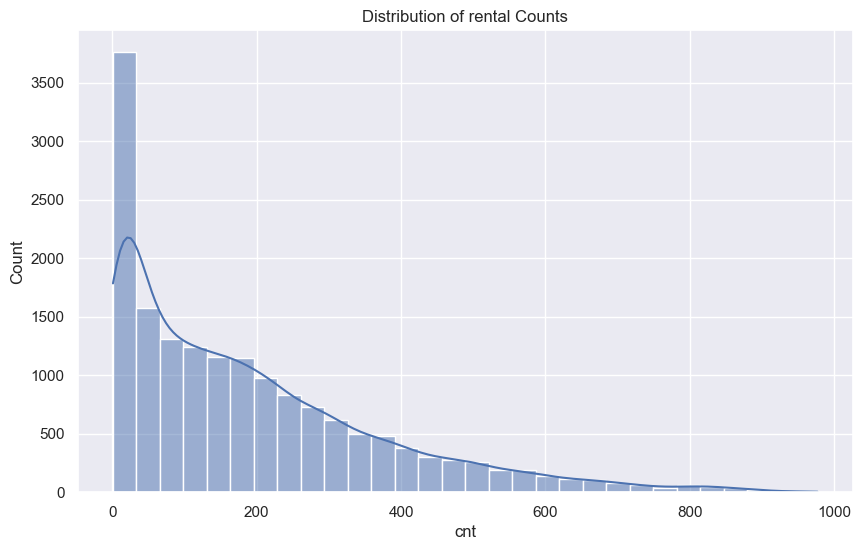

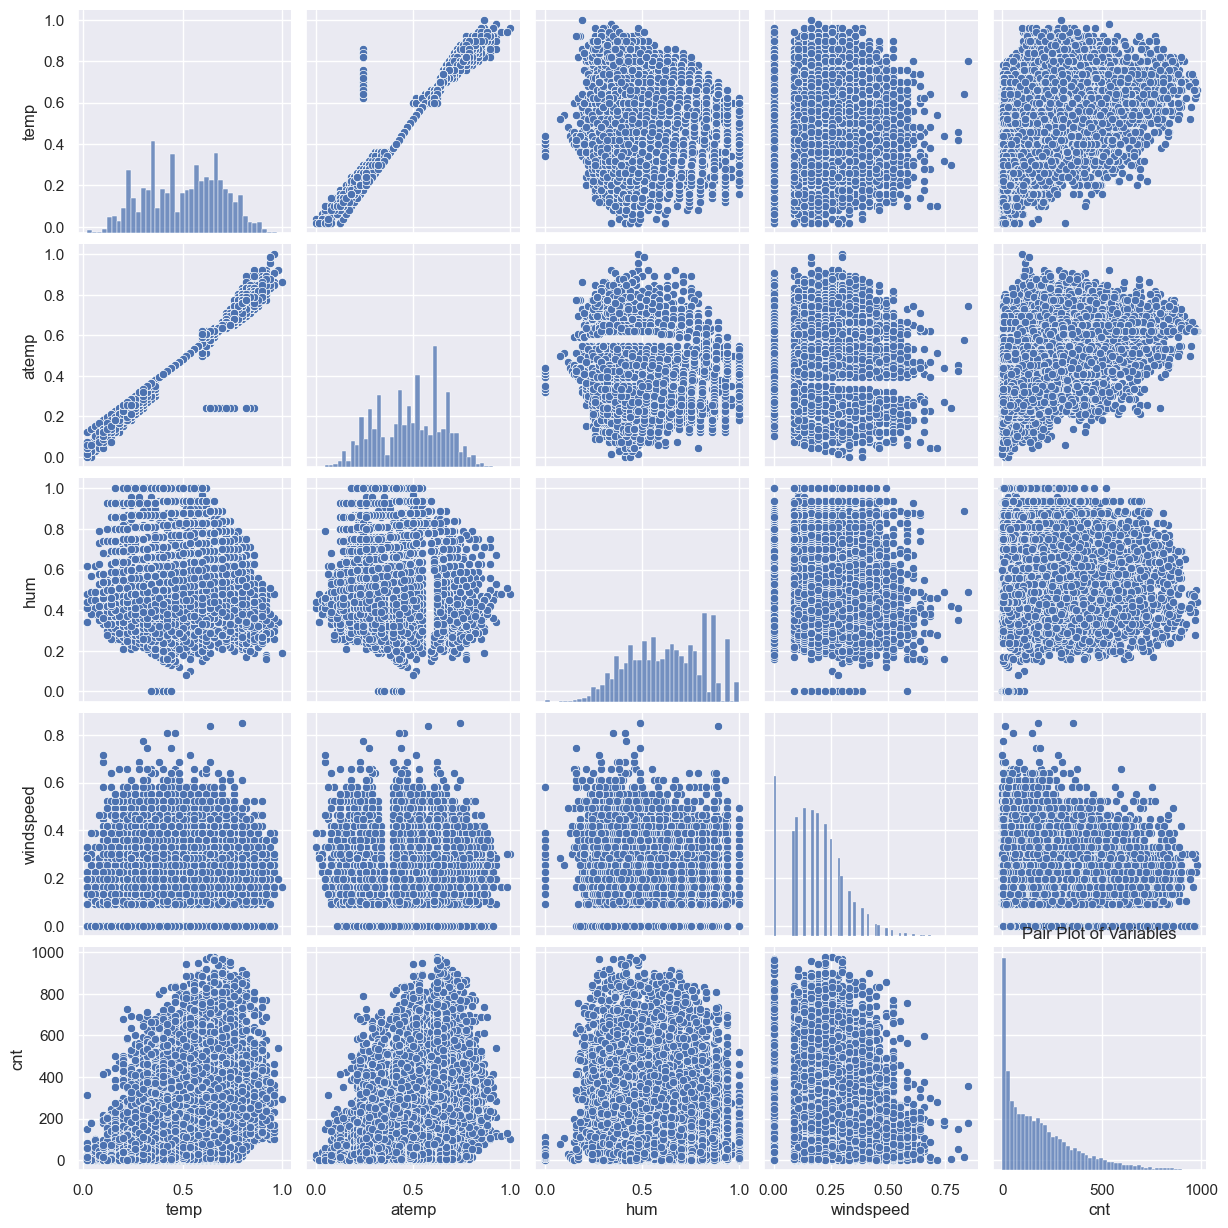

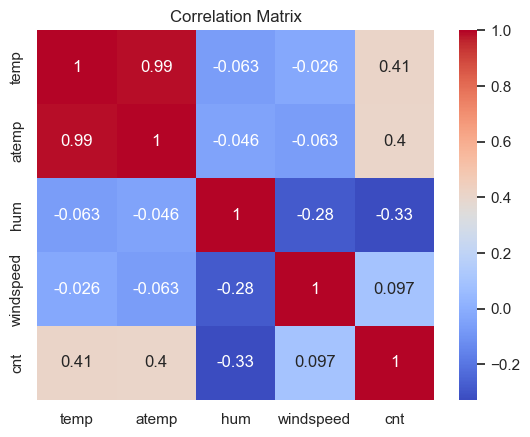

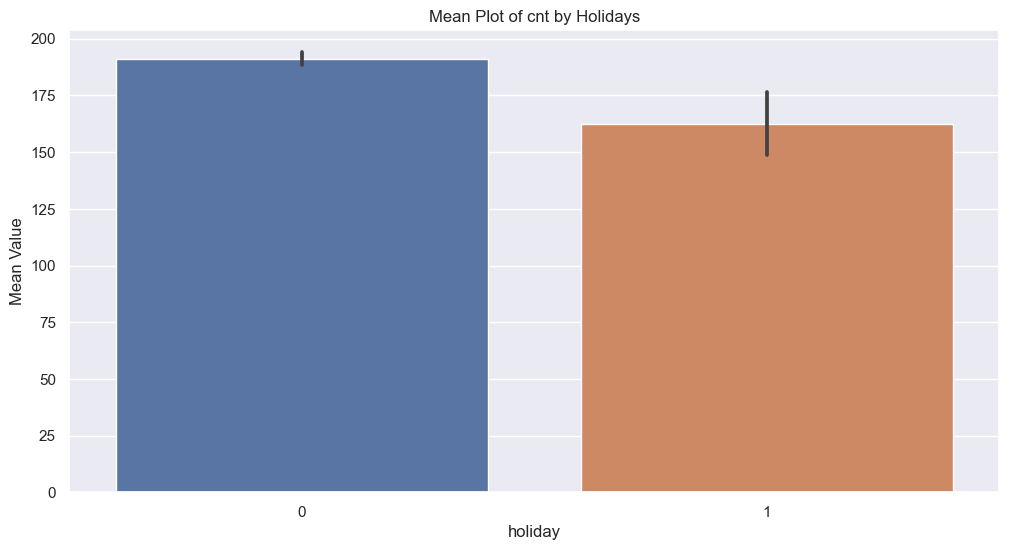

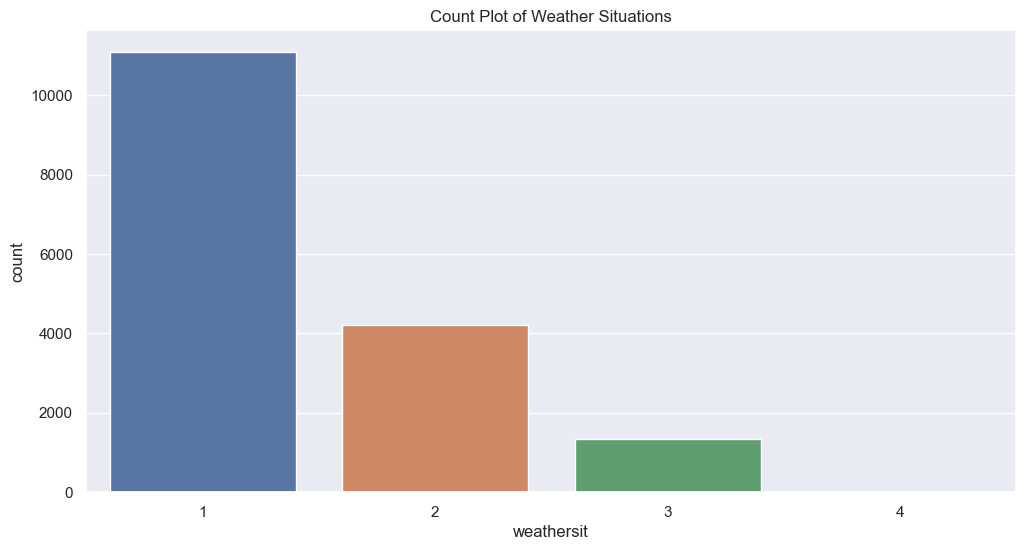

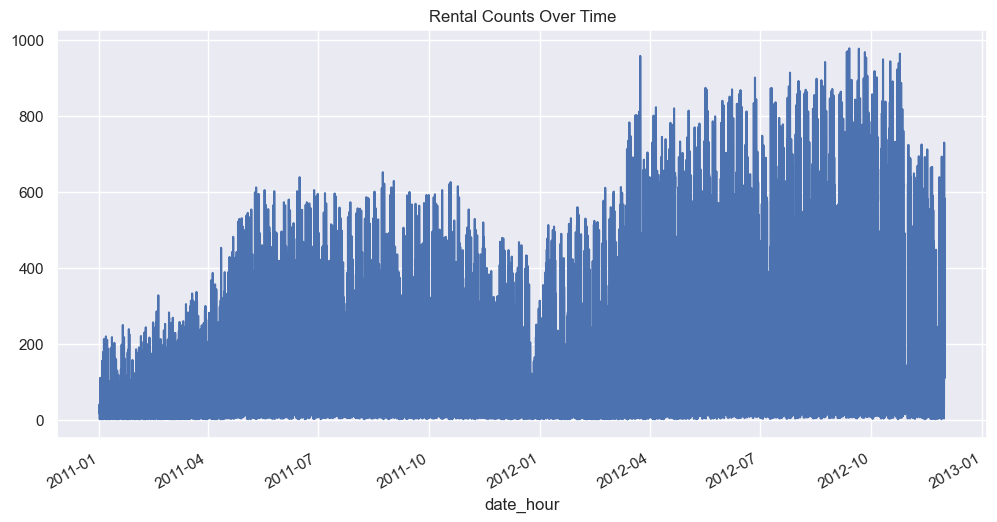

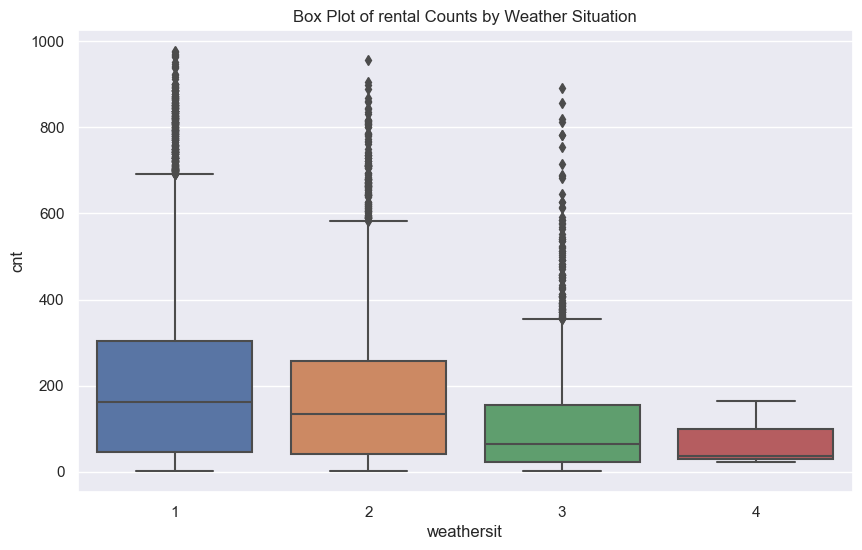

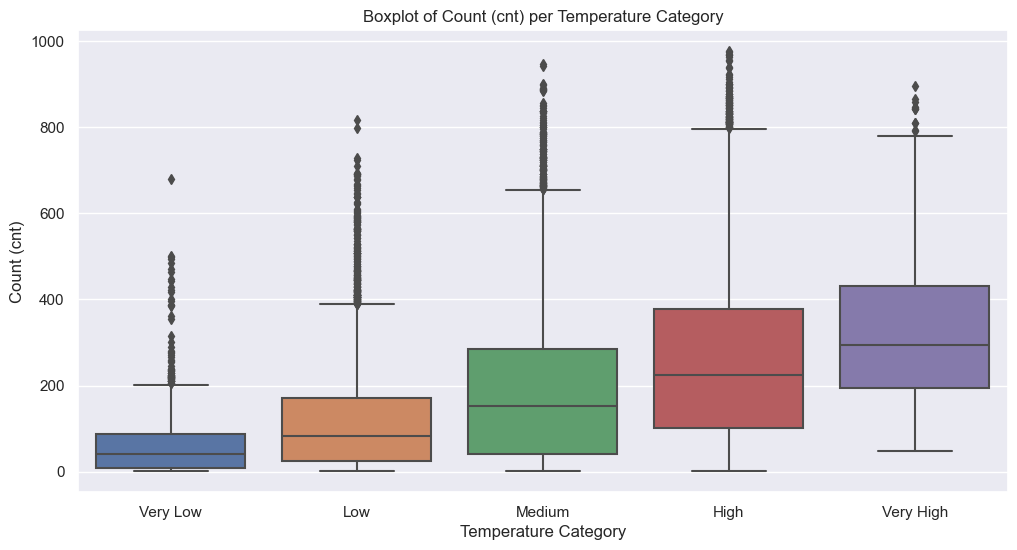

In [52]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(10, 6))
sns.histplot(df['cnt'], bins=30, kde=True)
plt.title('Distribution of rental Counts')
plt.show()

sns.pairplot(df[['temp', 'atemp', 'hum', 'windspeed', 'cnt']])
plt.title('Pair Plot of Variables')
plt.show()

correlation_matrix = df[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


plt.figure(figsize=(12, 6))
sns.barplot(x='holiday', y='cnt', data=df)
plt.title('Mean Plot of cnt by Holidays')
plt.ylabel('Mean Value')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='weathersit', data=df)
plt.title('Count Plot of Weather Situations')
plt.show()


df['date_hour'] = pd.to_datetime(df['date_hour'])
df.set_index('date_hour', inplace=True)

plt.figure(figsize=(12, 6))
df['cnt'].plot()
plt.title('Rental Counts Over Time')
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(x='weathersit', y='cnt', data=df)
plt.title('Box Plot of rental Counts by Weather Situation')
plt.show()

temperature_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0] 
temperature_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

plt.figure(figsize=(12, 6))
sns.boxplot(x=pd.cut(df['temp'], bins=temperature_bins, labels=temperature_labels, include_lowest=True), y='cnt', data=df)
plt.title('Boxplot of Count (cnt) per Temperature Category')
plt.xlabel('Temperature Category')
plt.ylabel('Count (cnt)')
plt.show()

## Hoofdstuk 2.3: EDA bevindingen

### Bevindingen

We hebben allereerst gezien dat er twee verschillende soorten temperatuur zijn en alhoewel we weten dat 'atemp' gebaseert is op hoe de temperatuur aanvoelt zien we in meerdere afbeeldingen dat de twee op elkaar lijken, beide hebben correlatie van ongeveer 0.4 tot de 'cnt' target kolom.

We zien in de visualisaties dat het verhuuraantal piekt in de spits tijden, dus rond 7 tot 9 uur 
s ’ochtends en 5 tot 6 uur s ’avonds, tussen deze pieken neemen de verkopen deels weer af naar een gematigde hoeveelheid. In de nacht nemen de aantallen extreem af maar blijven wel bestaan en dus is het huren nog wel mogelijk. Zoals te verwachten geven de visualisaties van de weeknummers en van de maanden min of meer hetzelfde resultaat namelijk dat in de zomer weken / maanden de verkopen een klein beetje toenemen en in de winter een klein beetje lager, de andere maanden zitten dus hiertussen en nemen toe tot de zomer en dalen weer tot de winter. De totale toename van huuraantallen is te zien in de boxplot van de jaren met een hoger aantal in 2012 ten opzichte van 2011.
in het scatterplot zien we dat er meer (extreeme) uitschieters zijn naarmate de tijd toeneemt, hoe betrouwbaar dit is valt nog te betwijfelen sinds naarmate de tijd toeneemt het gemiddelde van 'cnt' ook toeneemt en meer uitschieters dus logisch zijn. We hebben opgemerkt dat alhoewel 'cnt' met de tijd toeneemt er één extreem lage uitschieter was op 26 oktober 2012, op dat moment was er in washington een orkaan, wat de reden hiervoor waarschijnlijk is. Verder zijn we met behulp van de boxplots van de weer situaties dat er vier verschillende soorten zijn en we zien dat weer dat hoe meer punten er in een bepaalde situatie zitten hoe hoger de standaarddeviatie en hoe hoger de hoeveelheid buiten de boxplot. we zien verder dat rond december 2011 er een sterke afname was in 'cnt'. we dachten een duidelijk patroon te zien in de seizoenen, dus hebben we een aparte kolom aangemaakt om onderscheid te maken tussen de vier. hierna hebben we 'cnt' gevisualizeerd per seizoen waar we kunnen zien dat er in verhouding tot de andere seizoenen de 'cnt' waardes in de winter erg laag zijn en ze het hoogst zijn in de zomer. Dit sluit aan op onze analyse van de weken en maanden. Er valt bij windspeed te zien dat er een leegte zit tussen een windspeed van 0 en 0.2, dit zal waarschijnlijk betekenen dat alle windsnelheden lager dan 0.1 worden afgerond naar 0

In onze visualisatie van de temperatuur categorieën zie je dat de huuraantallen toenemen als de temperatuur hoger is, dus als de temperatuur stijgt dan nemen de verkopen ook toe waaruit we kunnen concluderen dat bij beter weer er meer verhuurd wordt. Wij vinden dit een belangrijke bevinding, hier kan namelijk iets mee gedaan worden. Het bedrijf dat verhuurt kan hier op in spelen en ook kunnen ze hun verwachtte verhuringen bijstellen als het weer zich anders gedraagt dan anders.

Ook zien we pieken om 8 uur 's ochtends en 5 uur 's middags, hieruit begrijpen wij dat het meeste verhuurt wordt tijdens de spits. Mensen zullen dus huren om naar of van werk te reizen. Dit is ook een belangrijke bevinding aangezien dit aangeeft dat werktijden ook invloed zullen hebben op de verhuur.

## Hoofdstuk 2.4: Timeseries analyse




 # Timeseries

Time series data is een verzameling van observaties die in de loop van de tijd zijn verzameld door periodieke metingen uit te voeren. De data die vast staat in een time series is dan ook altijd terug te lijden naar een tijdspunt in het verleden.
(InfluxData, 2021)

In ons project zullen wij een Time series analysis uitvoeren, hierbij wordt er een analyse gemaakt over een timeseries dataframe waarbij de data is verzameld op vaste tijds intervallen. In ons geval is het interval één uur gedurende een periode van 23 maanden.

### Forecasting

Tijdens de analyse zullen wij forecasting toepasen. Bij forecasting worden de timeseries index en de target variabele gegevens gebruikt om patronen te vinden  en toekomstige waarden te voorspellen. (InfluxData, 2021)

Time series bestaan uit verschillende componeten, namelijk de secular trend, seasonal trend, cyclical variations en irregular variations. (wallstreetmojo, 2022)

### Secular Trend

De trend in een timeseries is het langlopende patroon binnen de data. Het laat de verandering binnen de timeseries zien. De trend kan stijgend, dalend en neutraal zijn. (geeksforgeeks, 2023)
De trend toont dus voortgang van de data en doet dit zonder de invloeden van de seizoenen en andere fluctuaties. Voor het schatten van de trend maken wij gebruik van het voortschrijdend gemiddelde, dat gebruikt meerdere gegevenspunten rondom een willekeurig punt in de tijdsreeks. Hierbij is de frequentie van de gegevens de bepalende factor voor de lengte van het voortschrijdend gemiddelde venster.
(Machine learning week 9, 2023)
 
 

 

# Moving average

Voor tonen van de trend hebben wij eerst de Moving Average nodig. deze zullen wij tonen met behulp van code.
Hiervoor hebben wij een dataframe nodig met alleen de tijdseries index en de target values.




<Axes: xlabel='date_hour'>

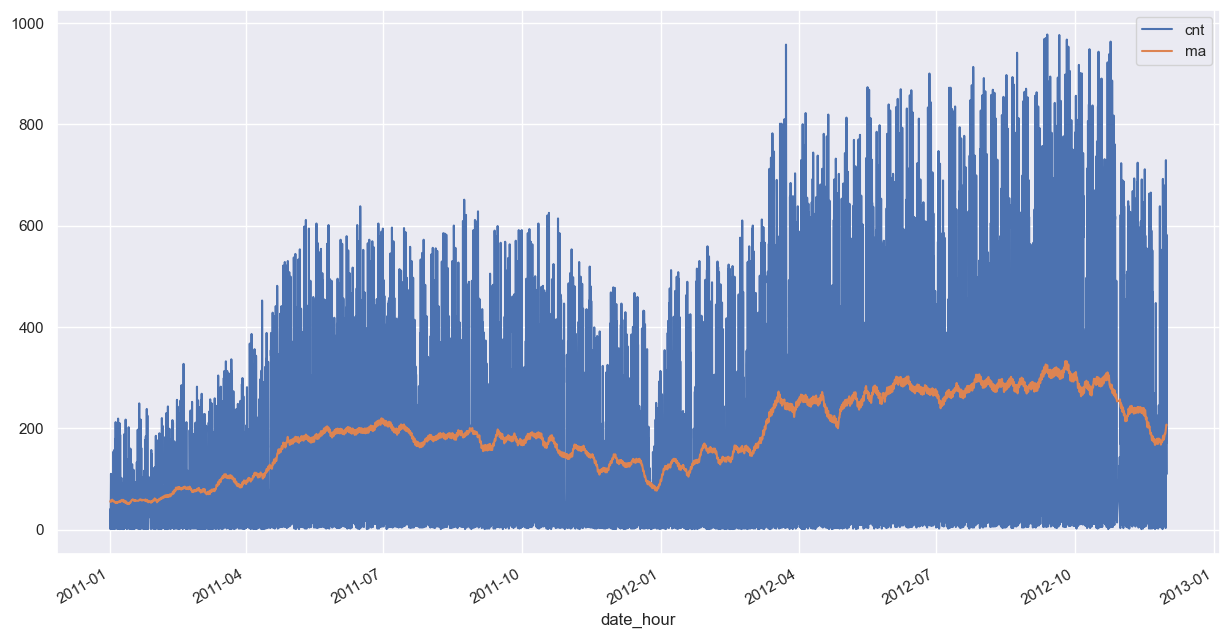

In [53]:
warnings.filterwarnings('ignore')
#Data inladen
ma_df = pd.read_csv("data/train.csv")

#Benodigde kolommen uit de train data pakken
dh_cnt = ma_df[['date_hour', 'cnt']]

#Tijdserie index aanmaken
dh_cnt['date_hour'] = pd.to_datetime(dh_cnt['date_hour'])

#index aanpassen
dh_cnt = dh_cnt.set_index('date_hour')

#Pandas rolling functie toepassen om moving average toe te voegen aan dataframe.
dh_cnt['ma']  = dh_cnt.rolling(window = 247, min_periods = 127,  center = True).mean()

#Moving average plotten tegenover de cnt
dh_cnt.plot(figsize=(15, 8))

#bron: (GeeksforGeeks, 2021)
#bron: (Pandas.DataFrame.Rolling — Pandas 2.1.3 documentation, z.d.) 

<Axes: xlabel='date_hour'>

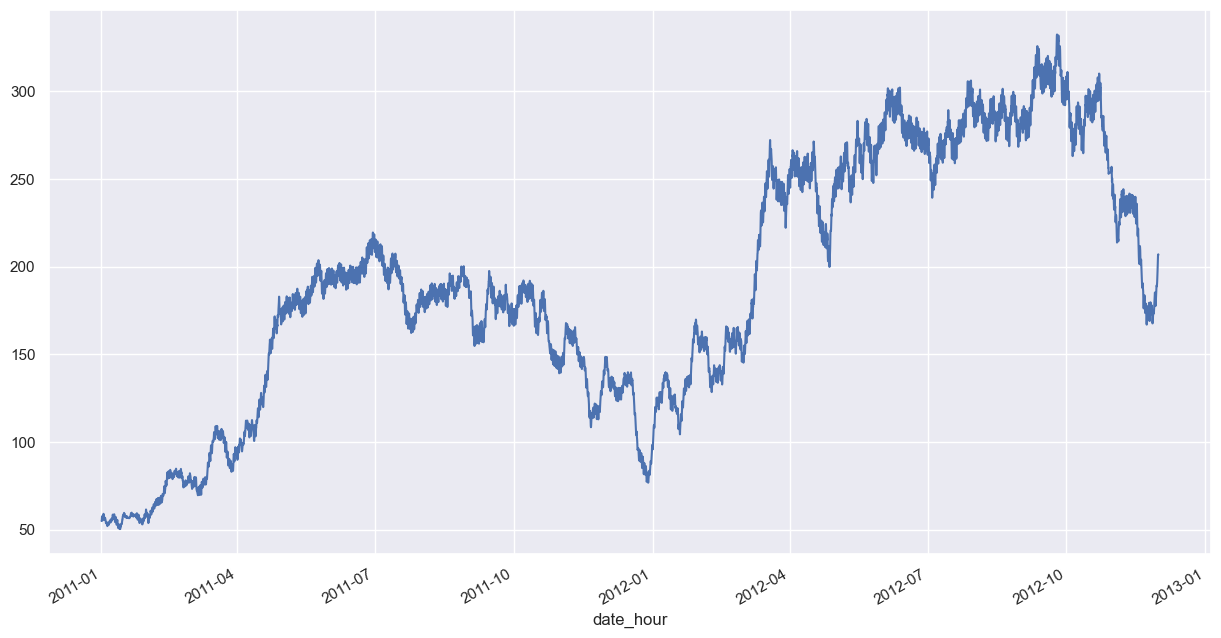

In [54]:
#Alleen moving average plotten
dh_cnt['ma'].plot(figsize=(15, 8))

In [55]:
display(dh_cnt)

,cnt,ma
date_hour,,
2011-01-01 00:00:00,16,NaN
2011-01-01 01:00:00,40,NaN
2011-01-01 02:00:00,32,NaN
2011-01-01 03:00:00,13,54.952756
2011-01-01 04:00:00,1,55.046875
...,...,...
2012-11-30 19:00:00,377,207.070312
2012-11-30 20:00:00,245,206.771654
2012-11-30 21:00:00,183,NaN


# Uitleg code moving average
In de bovenstaande code cellen hebben we eerst een DataFrame aangemaakt dat alleen de 'cnt' (aantal) per uur bevat. Vervolgens voegen we de kolom 'ma' toe, wat staat voor het voortschrijdend gemiddelde (moving average). Dit wordt gedaan met behulp van de Pandas functie 'rolling'. Hierin specificeren we dat het venster waarover het gemiddelde wordt berekend gelijk moet zijn aan 24 uur vermenigvuldigd met 7 dagen. Dit resulteert in het tonen van het voortschrijdend gemiddelde op een wekelijkse basis. Het gebruik van een wekelijks venster zorgt voor een duidelijkere verloop, waardoor de lijn beter interpreteerbaar wordt.

Vervolgens presenteren we het DataFrame door middel van een eenvoudige grafiek, waarbij we specifiek de moving average-kolom tegenover 'date_hour' plotten om een duidelijker beeld te krijgen van de trend.

Ten slotte tonen we het DataFrame inclusief de nieuwe kolom voor het voortschrijdend gemiddelde.

# Moving average bevindingen
De toepassing van het voortschrijdend gemiddelde biedt een verbeterd inzicht in de algemene trend van de tijdreeks. Gedurende het eerste jaar (2011) zien we een stijging in het gemiddelde, maar in de laatste paar maanden is er een neerwaartse trend waar te nemen. In het tweede jaar begint het gemiddelde opnieuw te stijgen, en opvallend is dat het nu aanzienlijk hoger is dan in het eerste jaar. Naar het einde van het tweede jaar toe is er opnieuw een daling in het gemiddelde, maar het blijft nog steeds hoger dan in het eerste jaar.

Deze patronen suggereren mogelijke seizoensgebondenheid of langetermijntrends in de gegevens, waardoor het voortschrijdend gemiddelde nuttig is om de overkoepelende bewegingen in de tijdreeks te identificeren.

# Seasonal decompose

In [56]:
#datapunten verkleinen

dcp_df = pd.DataFrame(df.copy())
dcp_df = pd.DataFrame(dcp_df['cnt'])
dcp_df = dcp_df.resample('D').sum()

display(dcp_df)
#bron: (Pandas.Series.resample — Pandas 2.1.3 documentation, z.d.)


,cnt
date_hour,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600
...,...
2012-11-26,5087
2012-11-27,3959
2012-11-28,5260


Voorheen hebben wij de trend, seasonal en residuals getoond met het orginele dataframe. Dit dataframe bevatte echter heel veel datapunten. Hierdoor kregen wij plots die onleesbaar zijn en niet goed de patronen konden visualiseren. Daarom hebben wij de resample functie gebruikt. Zo konden wij een dataframe maken waar de aantallen per dag worden getoond. Hiermee kunnen wij later beter leesbare plots produceren.

In [57]:
def decompose_ts(series, period=None):
    """
    Decomposeert een tijdreeks in trend, seizoensgebonden en residuale componenten met behulp van additieve decompositie.

    Parameters:
    
series (pandas.Series): De tijdreeks die moet worden gedecomposeerd.
period (int, optional): Het aantal waarnemingen per seizoen. Als dit niet is opgegeven, wordt de periode automatisch gedetecteerd.

    Returns:
    
pandas.Series: Trendcomponent van de tijdreeks.
pandas.Series: Seizoensgebonden component van de tijdreeks.
pandas.Series: Residuale component van de tijdreeks.

    De functie maakt gebruik van de additieve decompositiemethode uit statsmodels.
    """
    result = sm.tsa.seasonal_decompose(series, model='additive', period=period)
    return result.trend, result.seasonal, result.resid

#trend, seasonal en resid aanmaken
trend, seasonal, resid = decompose_ts(dcp_df, period=24*7)

# Toelichting code en periode.
In de bovenstaande code maken wij de functie decompose_ts aan. Vervolgens voeren wij de functie uit, in het specifieke geval wordt de decompositie toegepast op een tijdreeks (dcp_df) met een opgegeven periode van 24*7. Deze keuze voor een periode komt overeen met een week. De reden achter deze keuze is dat het voor ons zinvol is om de decompositie op een wekelijkse basis uit te voeren, vooral omdat er wekelijkse patronen in de tijdreeks zitten. Door een periode van een week te kiezen, kunnen seizoensgebonden patronen op wekelijkse basis beter worden gevisualiseerd en geanalyseerd, waardoor de interpretatie van de trend, seizoensgebonden en residuale componenten makkelijker wordt.

In [58]:
def plot_ts(df, trend, seasonal, residuals):
    """
    Functie om de tijdreeks, trend, seizoensgebonden en residuale componenten te plotten.

    Parameters:
    - df (pandas.DataFrame): DataFrame met de originele tijdreeks.
    - trend (pandas.Series): Serie met de trendcomponent van de tijdreeks.
    - seasonal (pandas.Series): Serie met de seizoensgebonden component van de tijdreeks.
    - residuals (pandas.Series): Serie met de residuale component van de tijdreeks.

    De functie maakt een 3x1 subplot en plaatst de originele tijdreeks en de trendcomponent op de eerste subplot.
    De seizoensgebonden component wordt geplot op de tweede subplot, en de residuale component wordt geplot op de derde subplot.
    Elke subplot bevat een legenda en een titel.

    De plot wordt weergegeven met behulp van Matplotlib.
    """
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 12))

   
    axes[0].plot(df.index, df['cnt'], color='blue', label='Originele Tijdreeks')
    axes[0].plot(df.index, trend, color='red', linestyle='dashed', label='Trend')
    axes[0].set_title('Originele tijdreeks en trend')
    axes[0].legend()

    
    axes[1].plot(df.index, seasonal, color='green', label='Seizoenscomponent')
    axes[1].set_title('Seizoenscomponent')
    axes[1].legend()

    
    axes[2].plot(df.index, residuals, color='red', label='Residuale component')
    axes[2].set_title('Residuale component')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

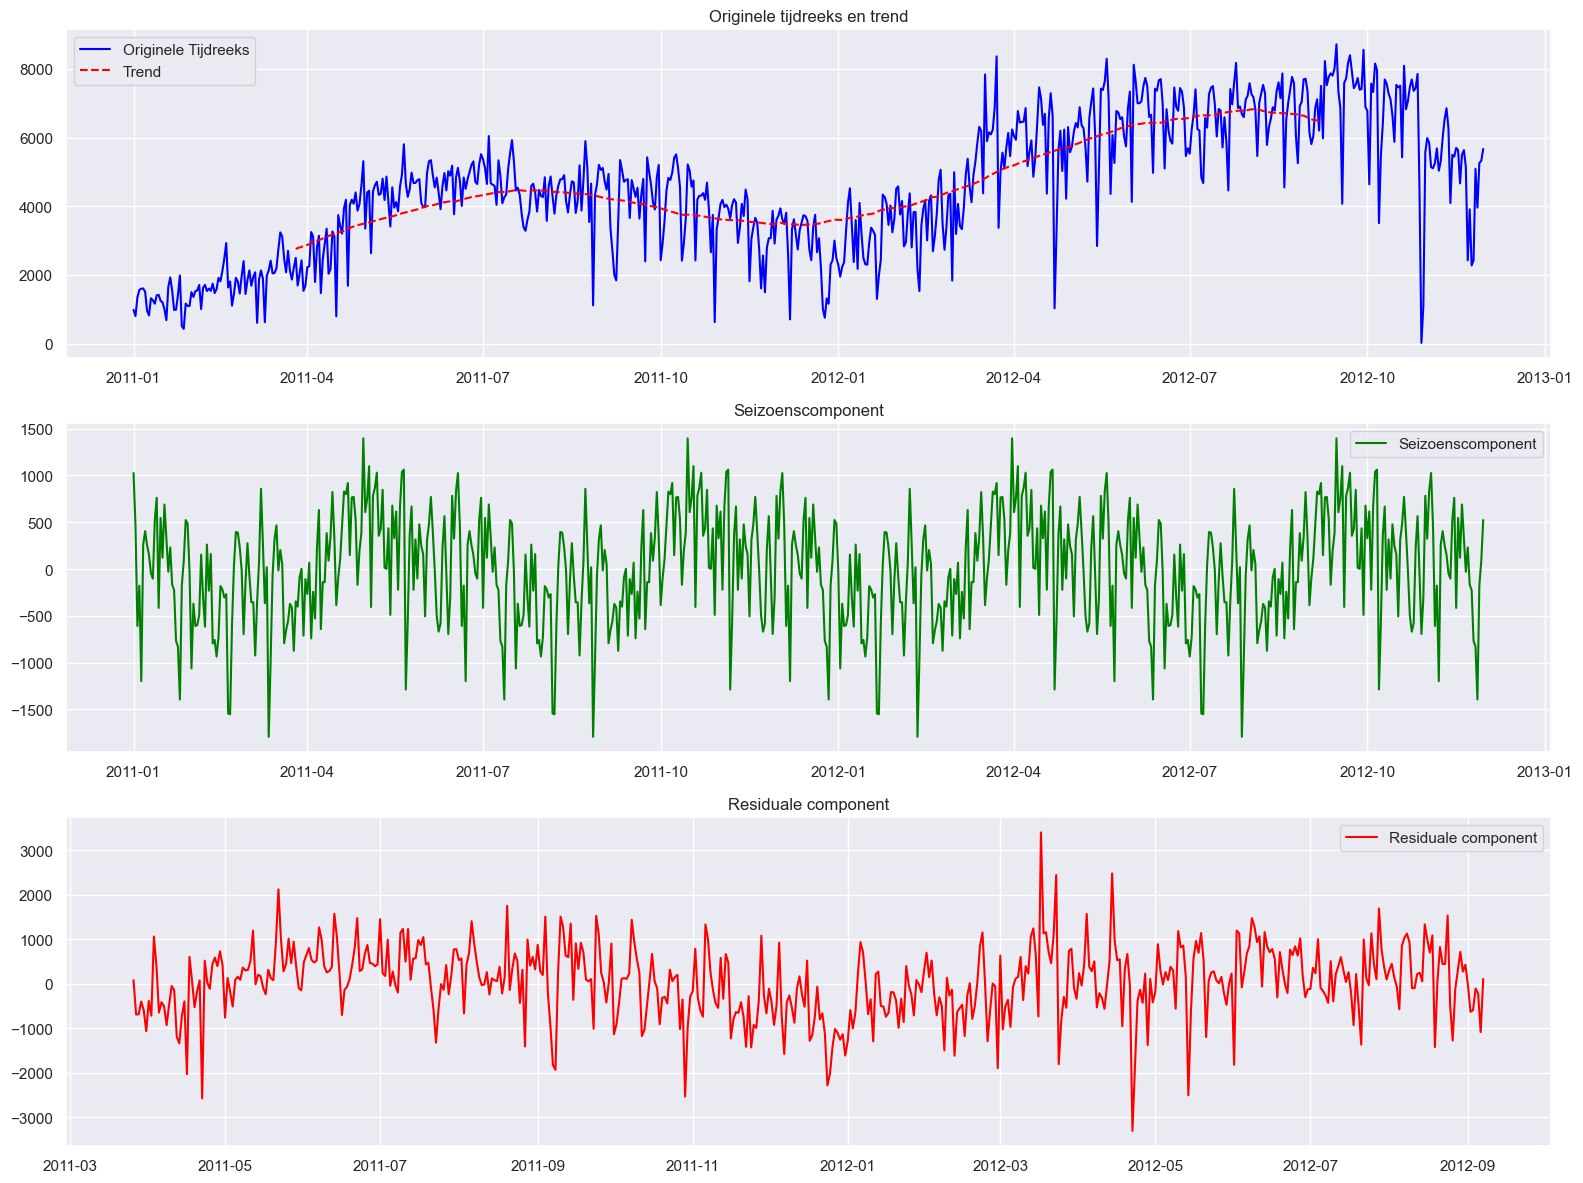

In [59]:
#De functie uitvoeren
plot_ts(dcp_df, trend, seasonal, resid)

Hierboven tonen wij drie plots.
In de eerste  plot tonen wij de timeseries met de count opgesomd per dag. Indezelfde grafiek voor ook trend getoond. Zo kan in een oogopslag de algemene richting van het model onderzocht worden.

In de tweede plot is het seizoenscomponent van de timeseries te zien. Met deze plot is het mogelijk om patronen te tonen die zich met regelmaat herhalen.
Verder laat de laaste plot de residuen van de timeseries zien.

## Hoofdstuk 3: Time series feature engineering

## Time Series Feature Engineering: Seasonal Patterns
### Seizoenspatronen
Seizoenspatronen, ofwel seizoensgebonden patronen, zijn herhalende trends met een vaste tijdsduur die pieken of dalen in een tijdreeks kunnen voorspellen. Om deze patronen te onderzoeken, hebben we gebruikgemaakt van Fourier-transformatie. Deze transformatie zet de tijdreeks om in frequenties met bijbehorende amplitudes. We hebben een drempelwaarde ingesteld op $1.8\cdot{10}^5$ om alleen frequenties met voldoende significantie te behouden.

De volgende tijdseenheden vertoonden frequenties met een amplitude hoger dan de drempelwaarde:

- 1 jaar
- 2/3 jaar (231 dagen)
- 1/2 jaar (173 dagen)
- 1 dag
- 1/2 dag (12 uur)
- 1/3 dag (8 uur)
- 1/5 dag (4.8 uur)

De keuze van deze tijdseenheden is gebaseerd op de waarde van de amplitude en de relevantie ervan voor de voorspelling van pieken en dalen in de tijdreeks. Het stellen van de drempelwaarde op $1.8\cdot{10}^5$ was een afweging om alleen de meest significante frequenties te behouden.

Het opmerkelijke hierbij is dat veel van deze tijdseenheden overeenkomen met gebruikelijke tijdsduren in ons dagelijks leven. Hierdoor kunnen we logischerwijs verklaren waarom deze frequenties als seizoenspatronen zijn geïdentificeerd.

De geobserveerde tijdseenheden suggereren de aanwezigheid van seizoensgebonden gedrag in de tijdreeks, wat van groot belang kan zijn bij het voorspellen van toekomstige waarden. In de verdere analyse kunnen we deze seizoenspatronen integreren om de nauwkeurigheid van onze voorspellingen te verbeteren.
(2.3 Time Series Patterns | Forecasting: Principles and Practice (2nd Ed), z.d.)

### Fourier transformatie
De Fourier-transformatie is een krachtige wiskundige techniek die wordt gebruikt om een functie in de tijd (of ruimte) te decomponeren in een reeks sinus- en cosinuscomponenten, ook wel frequentiecomponenten genoemd. Deze transformatie is bijzonder nuttig bij het analyseren van tijdreeksen met seizoenspatronen omdat het ons in staat stelt om de aanwezigheid van cyclische patronen op verschillende tijdschalen te identificeren.

De continue Fourier-transformatie van een functie \(f(t)\) is gegeven door de volgende formule:

$
F(\omega) = \int_{-\infty}^{\infty} f(t) \cdot e^{-i\omega t} \, dt
$

Hierbij is:
- $F(\omega)$ de Fourier-getransformeerde van $f(t)$,
- $\omega$ de frequentie,
- $i$ de imaginaire eenheid $(i^2 = -1)$,
- $t$ de tijd, en
- $f(t)$ de oorspronkelijke functie in de tijd.

De discrete vorm van de Fourier-transformatie, die vaak wordt toegepast op discrete tijdreeksen, zoals in ons geval, is gegeven door:

$
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i \frac{2\pi}{N}kn}
$

Hierbij is:
- $X_k$ de $k$-de component van de Fourier-getransformeerde,
- $x_n$ het $n$-de punt in de tijdreeks,
- $N$ het totale aantal punten in de tijdreeks, en
- $k$ de index van de frequentiecomponent.

Wanneer we de Fourier-transformatie toepassen op een tijdreeks, krijgen we een spectrum van frequentiecomponenten, elk met een bijbehorende amplitude. In het geval van tijdreeksen met seizoenspatronen, zullen bepaalde frequenties en hun amplitudes opvallen, wat aangeeft welke cyclische patronen aanwezig zijn in de data.(3Blue1Brown, 2018)

Door deze seizoensgebonden frequenties te identificeren en hun amplitudes te analyseren, kunnen we inzicht krijgen in de regelmatige patronen die zich herhalen in de tijdreeks. Dit stelt ons in staat om beter voorbereid te zijn op toekomstige schommelingen en deze in overweging te nemen bij het maken van voorspellingen.


In [60]:
warnings.filterwarnings('ignore')
def fft_freq(values, threshold):
    """
    Executes the fourier transformation, cleans the results with the threshold and creates a dataframe with the
    amplitude, frequencies, time in hours, days, months and years for all values where the amplitude is above the threshold
    and the frequency isn't zero.
    
    Parameters:
    - values: Series object with time series to do the fourier transformation on
    - threshold: integer with the threshold, this will be multiplied by 10^5 in the final threshold.
    
    """
    fig = plt.figure(figsize=(10, 4))
    
    freq = np.fft.fftfreq(len(values), 1)
    raw_result = np.fft.fft(values)
    
    cleaned_raw_result =  np.array([x if (x >= threshold*10**5) | (x <= -threshold*10**5) else 0 for x in raw_result])
    
    result = np.abs(raw_result)
    
    cleaned_result = np.array([x if (x >= threshold*10**5) & (y > 0) else 0 for x, y in zip(result, freq)])
    
    plt.plot(freq, raw_result)
    plt.xlim([-0.02, 0.13])
    plt.ylim([-5*10**5, 3.5*10**6])
    plt.axhline(threshold*10**5, color='green', dashes=(5, 5))
    
    fft_df = pd.DataFrame({'amplitude':cleaned_result[cleaned_result > 0][1:]})
    fft_df['freq'] = freq[cleaned_result > 0][1:]
    fft_df['duur in uren'] = 1/fft_df['freq']
    fft_df['duur in dagen'] = 1/fft_df['freq']/24
    fft_df['duur in maanden'] = 1/fft_df['freq']/24/(365/12)
    fft_df['duur in jaren'] = 1/fft_df['freq']/24/365
    
    fft_df['freq'] = [fft_df['freq'][0]] + [x if (x-y > x*0.1) else None 
                           for x, y in zip(fft_df['freq'][1:], fft_df['freq'][:-1])]
    
    fft_df = fft_df.dropna().reset_index(drop=True)
    
    return fft_df, freq, cleaned_raw_result

,amplitude,freq,duur in uren,duur in dagen,duur in maanden,duur in jaren
0,560236.241034,0.000120,8318.500000,346.604167,11.395205,0.949600
1,217822.744688,0.000180,5545.666667,231.069444,7.596804,0.633067
2,249918.605480,0.000240,4159.250000,173.302083,5.697603,0.474800
3,702799.953019,0.041594,24.041908,1.001746,0.032934,0.002745
4,306064.251401,0.077418,12.916925,0.538205,0.017694,0.001475
5,204856.186038,0.124962,8.002405,0.333434,0.010962,0.000914
6,180934.849803,0.208271,4.801443,0.200060,0.006577,0.000548


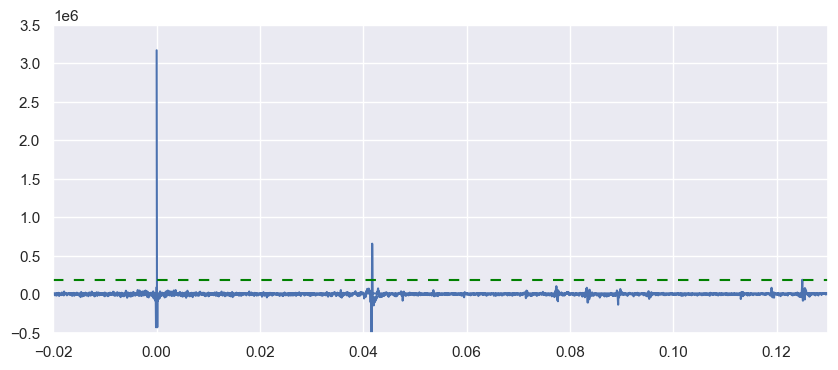

In [61]:
fft_df, freq, result = fft_freq(df['cnt'], 1.8)
display(fft_df)

### Inverse fourier transformatie
Nu we de fourier transformatie hebben gedaan, de waardes hebben opgeschoond en de relevante frequenties hebben. Kunnen we de inverse van de fourier transformatie uitvoeren. Dit betekent dat we van frequenties en amplitudes weer terug gaan naar een tijd reeks. Hiermee kunnen we zien wat de impact is van de meest relevante frequenties en hoe de grafiek eruit had gezien als we alleen deze frequenties in de data zouden hebben.

In [62]:
df = df.reset_index()

,date_hour,cnt,week
0,2011-01-01 00:00:00,187.990890,52
1,2011-01-01 01:00:00,184.437853,52
2,2011-01-01 02:00:00,165.951396,52
3,2011-01-01 03:00:00,140.646468,52
4,2011-01-01 04:00:00,120.002589,52
...,...,...,...
16632,2012-11-30 19:00:00,146.349680,48
16633,2012-11-30 20:00:00,138.358083,48
16634,2012-11-30 21:00:00,142.132687,48
16635,2012-11-30 22:00:00,157.456688,48


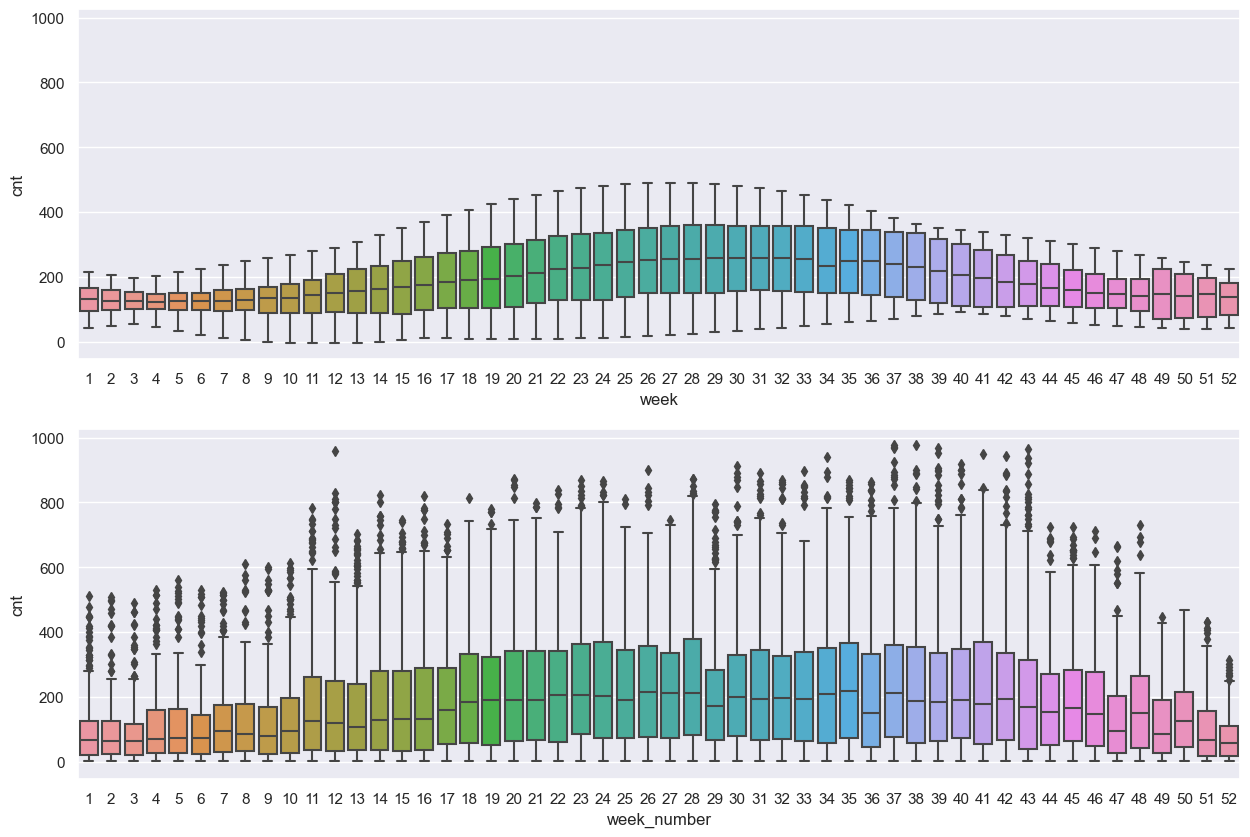

In [63]:
warnings.filterwarnings('ignore')
def inverted_fft(result, df):
    """
    Uses the results of a cleaned fourier transformation to go back to a time series and puts this in a pandas DataFrame 
    with a time series, target column and a week column
    
    Parameters:
    - result: results of a cleaned fourier transformation done with np.fft.fft
    - df: pandas DataFrame with the original time series that was used to generate the results
    """
    cnt = np.fft.ifft(result).real
    
    
    ifft_df = pd.DataFrame({'date_hour': df['date_hour'], 'cnt': cnt})
    ifft_df['week'] = ifft_df['date_hour'].dt.isocalendar().week

    return ifft_df
    
def compare_ifft(df, ifft_df):
    """
    Plots 2 boxplots to compare the original to the inverse fourier transformed Dataframe from the cleaned fourier transformation

    Parameters:
    
    - df: pandas DataFrame with the original time series
    - ifft_df: pandas DataFrame with the inverse fourier transformation from the cleaned fourier transformation from the original time series
    """
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharey=True)
    sns.boxplot(x=ifft_df['week'], y=ifft_df['cnt'], ax=axes[0])
    sns.boxplot(data=df, x='week_number', y='cnt', ax=axes[1])
    
    
ifft_df = inverted_fft(result, df)
display(ifft_df)

compare_ifft(df, ifft_df)

### Inverse fourier vs Originele tijdserie
wij zien dat de inverse fourier mooie inzichten geven over de data. De originele tijdserie data is rommelig en het is moeilijk er duidelijke inzichten uit te halen, hier komt de in inverse fourier van de tijdserie te pas. Deze bestaat uit alleen de grootste frequenties die in de originele fourier te zien waren. Wij zien een toeneming van de cnt in de weken tussen 10 en 40. Dit is een groot bereik maar dat komt omdat het een langzame stijging is en daarna ook langzaam afneemt. Met een piek rond week 30. Dit komt overeen met de zomermaanden, de verhuuraantallen stijgen zodra het warmer wordt en naarmate de zomer eindigd gaat de temperatuur omlaag en wordt er ook minder verhuurd.

Ook willen we erbij vermelden dat we het nu alleen over de temperatuur hebben van de zomermaanden maar het is natuurlijk mogelijk dat er andere factoren meespelen die in de zomermaanden meer invloed hebben en dus de verhuuraantallen kunnen verhogen.

Ook zien we een kleine piek rond week 49, dit komt omdat de data van 2012 stopt bij week 48. Hierdoor zijn deze weken uit balans en komt hier een kleine piek die wij niet zouden verwachten als de data compleet was.


### Feature engineering
Door te kijken naar de frequenties die uit de fourier analyse komt kunnen wij extra kolommen toevoegen die sinus en cosinus golven toevoegd als kolom. Hierdoor kan een model deze frequenties ook benutten en zo zorgen voor betere voorspellingen. Dit helpt het model aangezien er al een hoop van het werk is gedaan om de huidige tijdsreeks na te bootsen.

In [64]:
annual_fourier = CalendarFourier(freq='A', order =  1)
quarterly_fourier = CalendarFourier(freq='M', order =  1)
daily_fourier = CalendarFourier(freq='D', order = 1)

In [65]:
dp = DeterministicProcess(index=df['date_hour'], constant=False, order=0, seasonal=False,
                          additional_terms = [annual_fourier, quarterly_fourier, daily_fourier], drop = False)

fourier_terms = dp.in_sample().reset_index()
fourier_terms['date_hour'] = pd.to_datetime(fourier_terms['date_hour'])
display(fourier_terms)

,date_hour,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(1,freq=M)","cos(1,freq=M)","sin(1,freq=D)","cos(1,freq=D)"
0,2011-01-01 00:00:00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,2011-01-01 01:00:00,0.000717,1.000000,0.008445,0.999964,0.258819,0.965926
2,2011-01-01 02:00:00,0.001435,0.999999,0.016889,0.999857,0.500000,0.866025
3,2011-01-01 03:00:00,0.002152,0.999998,0.025333,0.999679,0.707107,0.707107
4,2011-01-01 04:00:00,0.002869,0.999996,0.033774,0.999429,0.866025,0.500000
...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,-0.510494,0.859881,-0.043619,0.999048,-0.965926,0.258819
16633,2012-11-30 20:00:00,-0.509879,0.860246,-0.034899,0.999391,-0.866025,0.500000
16634,2012-11-30 21:00:00,-0.509263,0.860611,-0.026177,0.999657,-0.707107,0.707107
16635,2012-11-30 22:00:00,-0.508647,0.860975,-0.017452,0.999848,-0.500000,0.866025


(14975.0, 14977.0)

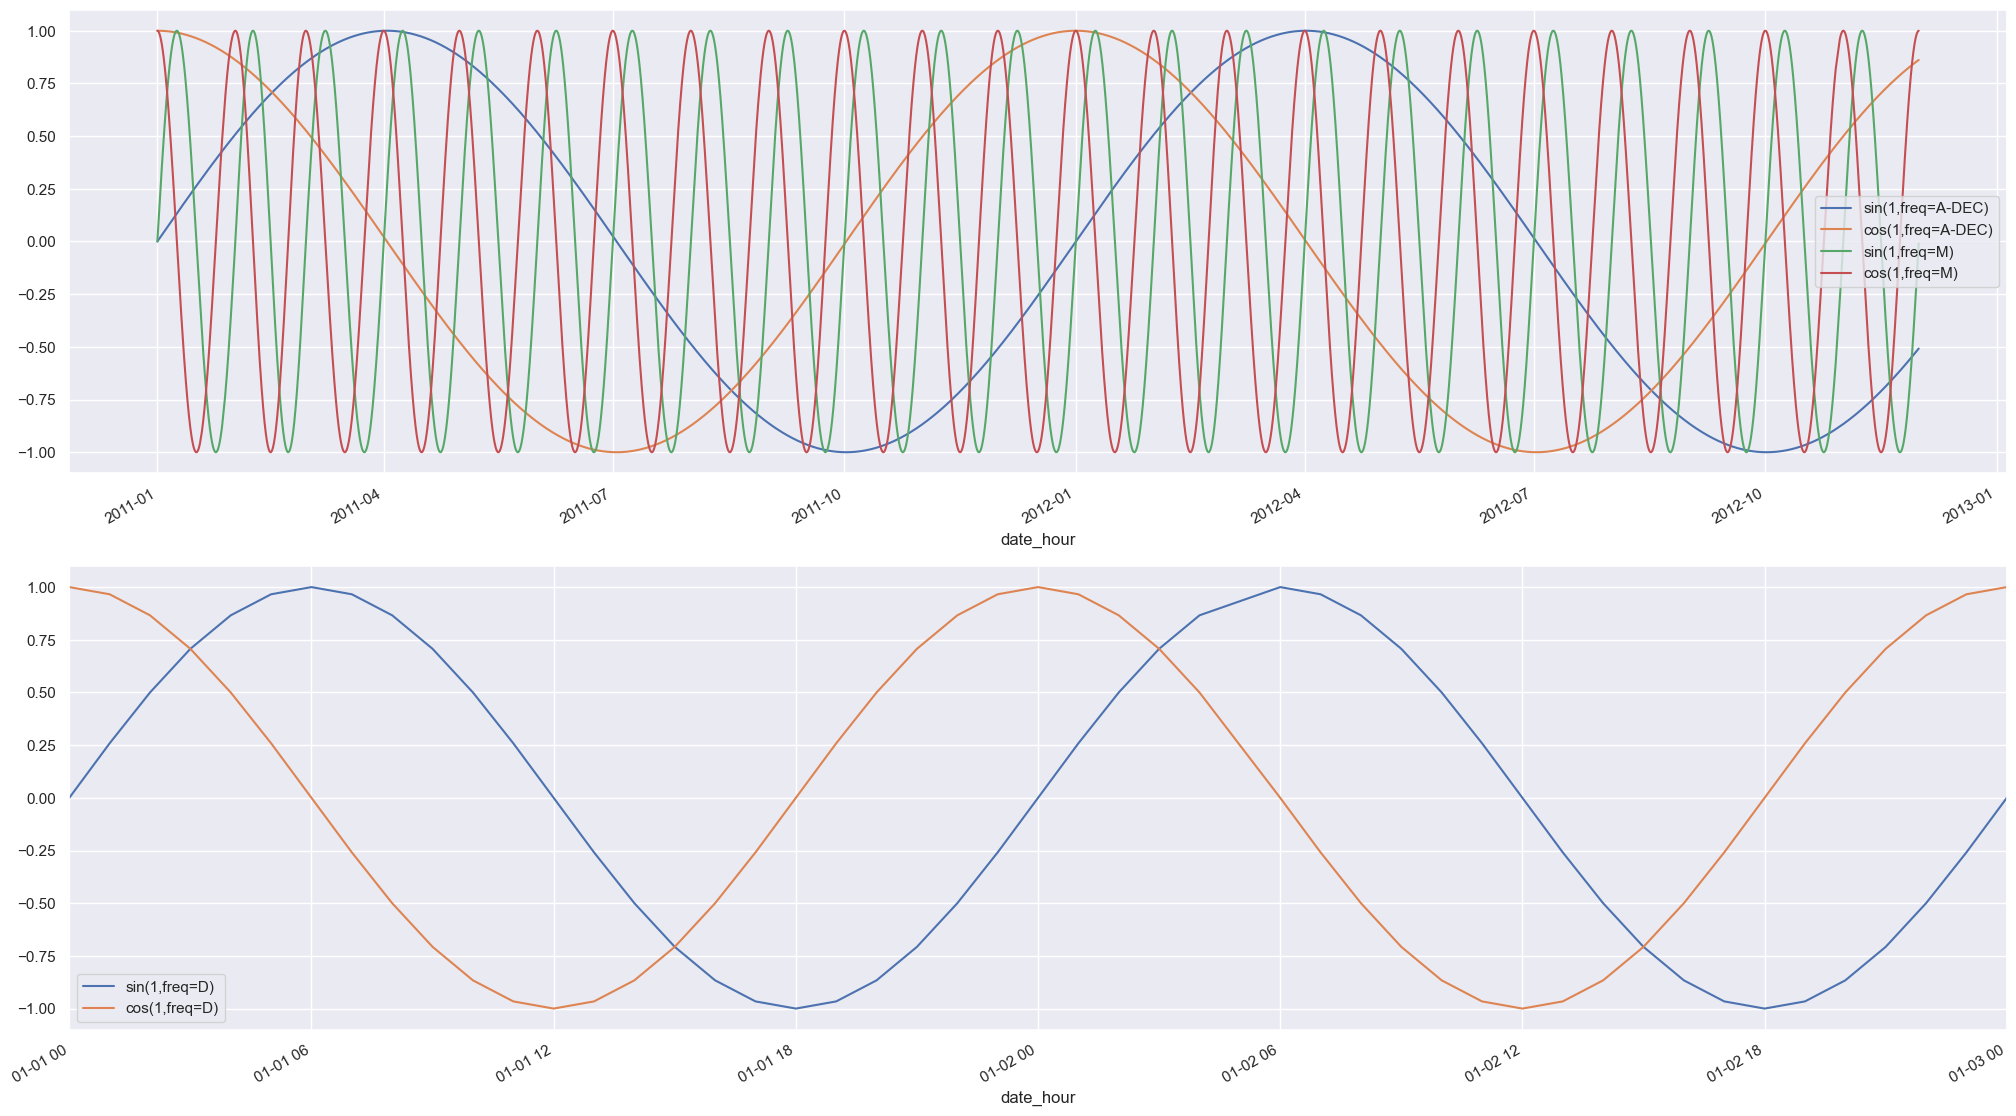

In [66]:
fig, ax = plt.subplots(2, 1, figsize=(25, 15))

ax[0] = fourier_terms.plot(ax=ax[0], y=fourier_terms.columns[1], x=('date_hour'))
ax[0] = fourier_terms.plot(ax=ax[0], y=fourier_terms.columns[2], x=('date_hour'))

ax[0] = fourier_terms.plot(ax=ax[0], y=fourier_terms.columns[3], x=('date_hour'))
ax[0] = fourier_terms.plot(ax=ax[0], y=fourier_terms.columns[4], x=('date_hour'))

ax[1] = fourier_terms.plot(ax=ax[1], y=fourier_terms.columns[5], x=('date_hour'))
ax[1] = fourier_terms.plot(ax=ax[1], y=fourier_terms.columns[6], x=('date_hour'))


day_start_date = pd.to_datetime('2011-01-01')
day_end_date = pd.to_datetime('2011-01-03')

ax[1].set_xlim(day_start_date, day_end_date)

In [67]:
cleaned_fourier_terms = fourier_terms.drop(['date_hour'], axis=1)

In [68]:
df = pd.concat([df, cleaned_fourier_terms], axis=1)
display(df)

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour,dayofweek,...,month,month_name,year,season,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(1,freq=M)","cos(1,freq=M)","sin(1,freq=D)","cos(1,freq=D)"
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,0,5,...,1,January,2011,winter,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,5,...,1,January,2011,winter,0.000717,1.000000,0.008445,0.999964,0.258819,0.965926
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2,5,...,1,January,2011,winter,0.001435,0.999999,0.016889,0.999857,0.500000,0.866025
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,3,5,...,1,January,2011,winter,0.002152,0.999998,0.025333,0.999679,0.707107,0.707107
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,4,5,...,1,January,2011,winter,0.002869,0.999996,0.033774,0.999429,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,19,4,...,11,November,2012,fall,-0.510494,0.859881,-0.043619,0.999048,-0.965926,0.258819
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,20,4,...,11,November,2012,fall,-0.509879,0.860246,-0.034899,0.999391,-0.866025,0.500000
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,21,4,...,11,November,2012,fall,-0.509263,0.860611,-0.026177,0.999657,-0.707107,0.707107
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163,22,4,...,11,November,2012,fall,-0.508647,0.860975,-0.017452,0.999848,-0.500000,0.866025


# Keuzes
De hebben bij het kiezen van de sin- en cosinus functies gekeken naar de periodiciteit van de data en hebben de frequenties van de jaren ("A") maandelijks ("M") en dagelijks ("D") gebruikt. Dit omdat de fourier analyse frequenties had bij ongeveer een jaar en ook bij een dag. Dit geeft aan dat hier trends en patronen van zijn in de tijdserie. Ook zagen wij frequenties bij verschillende maanden, dit gepaart met het feit dat we verschil zagen tussen de maanden in onze EDA hebben wij besloten de maandelijkse periode ook mee te nemen. 

Naast dit alles vinden wij het ook goede periodes omdat onze maatschappij daar op ingericht is. Wij leven op een dagelijkse basis, wij hebben onze kalender ingericht op de maanden en elk jaar komen dezelfde seizoenen, feestdagen, vakanties, etc. aan bod.

# Resultaten
We hebben de opgeschoonde Fourier-inverse vergelijkt met het orgineel, wij vinden dat onze reconstructie van de tijdreeks successvol was sinds de twee op elkaar lijken en de patronen zijn terug tezien. het vastleggen van de patronen is dus gelukt en op basis hiervan zullen we met onder andere autocorrelatie en cycli deze patronen proberen beter vast te leggen en te visualiseren.

## Autocorrelatie
Autocorrelatie verwijst naar de correlatie van een tijdreeks met zichzelf, gemeten op verschillende tijdsafstanden. Het kan helpen om patronen in de tijdreeks te identificeren en is essentieel bij het begrijpen van zowel cycli als seizoenspatronen.

### Partial autocorrelatie
Partial autocorrelatie is de autocorrelatie maar dan zonder terugkerende seizoenspatronen. Dit houdt in dat als je al een patroon hebt herkend bij bijvoorbeeld 24 uur dan word dit signaal onderdrukt elke nieuwe instantie van 24 uur. Hierdoor kan je makkelijker zien over er overlappende seizoenspatronen of cycli voorkomen en deze gebruiken voor de analyse van de tijdsreeks.

### Autocorrelatie en cycli:

Cycli in een tijdreeks verwijzen naar langere-termijnpatronen die zich herhalen, maar niet noodzakelijk met een vast tijdsinterval zoals seizoenspatronen. Cycli kunnen bijvoorbeeld betrekking hebben op economische cycli, die jaren kunnen beslaan. Wanneer we de autocorrelatiefunctie (ACF) toepassen op een tijdreeks met cycli, zullen we pieken zien op de momenten waarop de cycli herhalen.

### Autocorrelatie en seizoenspatronen:

Seizoenspatronen hebben betrekking op regelmatige fluctuaties in een tijdreeks met een vast tijdsinterval, zoals dagelijks, maandelijks of jaarlijks. Wanneer we de autocorrelatie toepassen op een tijdreeks met seizoenspatronen, zullen we duidelijke pieken zien op veelvouden van het seizoensinterval. Bijvoorbeeld, als het seizoensinterval dagelijks is, zouden we pieken verwachten op 24, 48, 72 enzovoort.
(Frost, 2022)

### Waarom cycli anders zijn dan seizoenspatronen:

Het belangrijkste verschil tussen cycli en seizoenspatronen ligt in de duur en het karakter van herhaling. Cycli hebben vaak een langere duur en minder consistente tijdsintervallen tussen herhalingen. Seizoenspatronen, aan de andere kant, hebben meestal een kortere en regelmatig herhalende duur.

Bij het analyseren van de autocorrelatie is het van belang om zowel cycli als seizoenspatronen in overweging te nemen, omdat beide types patronen van invloed kunnen zijn op het gedrag van de tijdreeks. Het identificeren van deze patronen met behulp van autocorrelatieanalyses kan helpen bij het modelleren en voorspellen van toekomstige waarden in de tijdreeks.

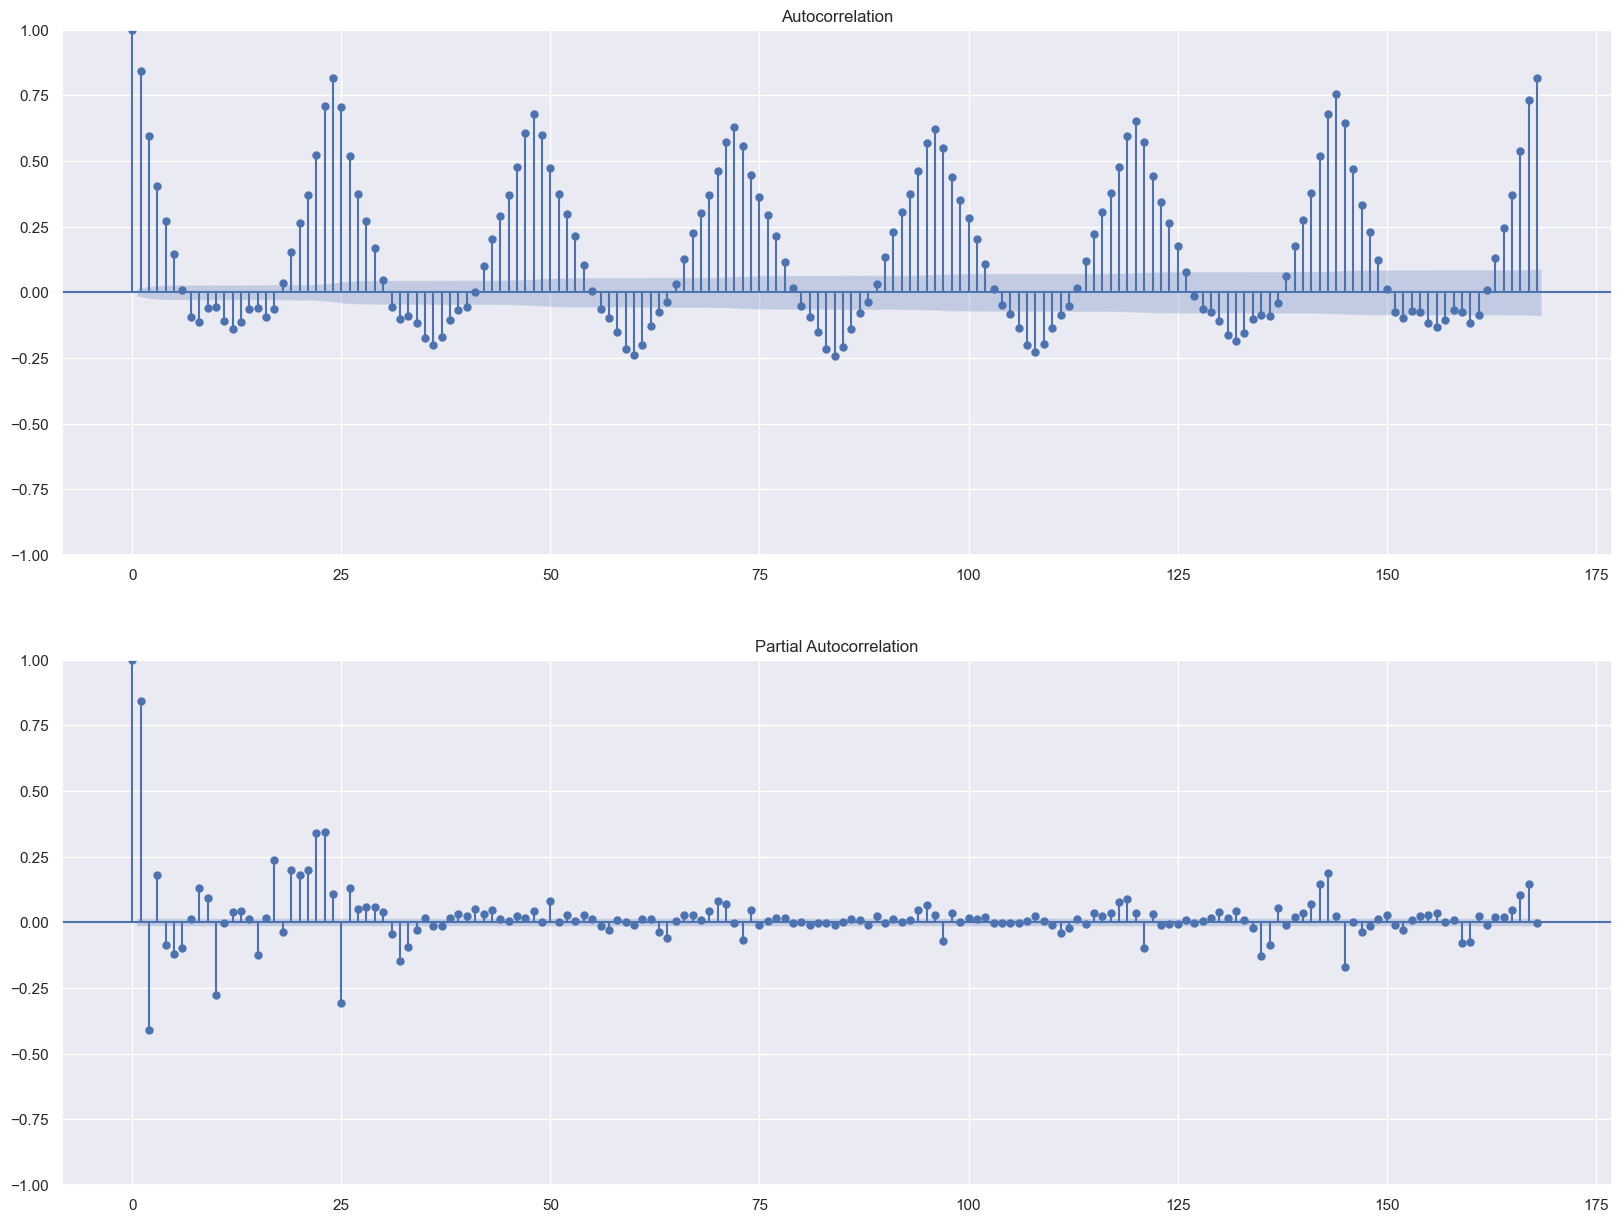

In [69]:
warnings.filterwarnings('ignore')
def auto_correlation(df):
    """
    Plots the autocorrelation and partial autocorrelation of the target column from the DataFrame
    
    Parameters:
    - df: Pandas Dataframe with the target column to plot the autocorrelation and partial autocorrelation from.
    """
    fig, ax = plt.subplots(2, 1, figsize=(20, 15))
    plot_acf(df['cnt'], ax=ax[0], lags=24*7)
    plot_pacf(df['cnt'], ax=ax[1], lags=24*7)

auto_correlation(df)

# Resultaten 
We zien zoals verwacht dat er een positieve piek is rond 24 steeds, er is dus een seizoensinterval van een dag
bij de partial autocorrelation laat zien dat er correlatie is die niet komt door tussenliggende lags, de waardes verschuiven naar 0 wat betekent dat de autocorrelatie al verklaart is in eerdere lags. hieruit kunnen we opmaken dat veel autocorrelatie zich in een seizoensinterval van 24 uur bevat en dat de interval van 24 uur het meest opmerkelijk is. we zien hier ook dat 's nachts er een negatieve correlatie is en dat deze redelijk constant is op de onregelmatige pieken na.

In de visualisatie van de Partial Autocorrelatie zien we dat op de intervallen van 24 uur toch nog wel wat pieken te vinden zijn alhoewel deze niet heel hoog of groot zijn. dit kan worden verklaart door de groei in totale verhuuraantallen over tijd. uit de visualisatie valt ook te halen dat, omdat de pieken in de pacf vaak op de verwachte intervallen liggen de groei in verhuuraantallen niet even verspreid is. de dalen in de nacht blijven hetzelfde, maar de hoogste punten van de dag worden steeds hoger.

Uit onze resultaten kunnen we concluderen dat het maken van extra functionaliteiten zoals uren per dag, seizoensgebonden indicatoren en trends ons goed kunnen helpen. dit versterkt onze conclusie uit de EDA.

## Hoofdstuk 4: Modelleren

In [70]:
X = df.drop(['cnt', 'weekday_name', 'month_name', 'date_hour'], axis=1)
y = df['cnt']

season_label_encoder = LabelEncoder()
X['season'] = season_label_encoder.fit_transform(X['season'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def train_and_evaluate_model(df):
    """
    Trains a Linear Regression model, performs hyperparameter tuning using GridSearchCV,
    and evaluates the model's performance using time series cross-validation.

    Args:
    - df: DataFrame containing the dataset

    Returns:
    - best_model: Best trained model
    - best_hyperparameters: Best hyperparameters selected by GridSearchCV
    - rmse: Root Mean Squared Error of the model
    - r_squared: R-squared value of the model
    """


    numerical_cols = X.columns.difference(['weekday_name', 'month_name', 'season'])

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, ['season'])
        ])

    model = make_pipeline(preprocessor, LinearRegression())

    param_grid = {
        'linearregression__fit_intercept': [True, False],
        'linearregression__copy_X': [True, False]
    }

    tscv = TimeSeriesSplit(n_splits=5)  

    grid_search = GridSearchCV(model, param_grid, cv=tscv)
    grid_search.fit(X_train, y_train)  

    best_model = grid_search.best_estimator_

    predictions = best_model.predict(X)
    rmse = mean_squared_error(y, predictions, squared=False)
    r_squared = r2_score(y, predictions)

    best_hyperparameters = grid_search.best_params_

    print(f"Best hyperparameters: {best_hyperparameters}")
    print(f"RMSE: {rmse}")
    print(f"R-squared: {r_squared}")

    return best_model, best_hyperparameters, rmse, r_squared

best_model, best_hyperparameters, rmse, r_squared = train_and_evaluate_model(df)




Best hyperparameters: {'linearregression__copy_X': True, 'linearregression__fit_intercept': True}
RMSE: 127.26903867538064
R-squared: 0.5111212310150665


# Lineaire regressie uitleg:
Lineaire regressie is model dat wordt gebruikt om de relatie tussen een afhankelijke variabele ($y$) en één of meer onafhankelijke variabelen ($x_1, x_2, \dots, x_n$) te modelleren door middel van een lineaire benadering. Het model probeert een lineaire relatie te vinden tussen de invoervariabelen en de doelvariabele door de best passende rechte lijn door de gegevens te bepalen.

De formule voor lineaire regressie is:

$$y = b_0 + b_1 x_1 + b_2 x_2 + \cdots + b_n x_n$$

Waar:
- $y$ is de voorspelde waarde van de afhankelijke variabele.
- $b_0$ snijpunt met de y-as.
- $b_1, b_2, \dots, b_n$ zijn de richtingscoëfficiënten.
- $x_1, x_2, \dots, x_n$ zijn de waarden van de onafhankelijke variabelen.

### Loss-functie:
De loss-functie voor lineaire regressie wordt meestal uitgedrukt als de gemiddelde kwadratische fout (Mean Squared Error - MSE). Het doel is om de coëfficiënten ($b_0, b_1, \dots, b_n$) te vinden die de som van de kwadraten van de afwijkingen tussen de voorspelde waarden en de werkelijke waarden minimaliseren.

De formule voor MSE is:

$\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$

Waar:
- $N$ is het aantal voorbeelden.
- $y_i$ zijn de werkelijke waarden.
- $\hat{y}_i$ zijn de voorspelde waarden.

De bedoeling is om de coëfficiënten ($b_0, b_1, \dots, b_n$) te vinden die de MSE minimaliseren, dus de voorspellingen zo dicht mogelijk bij de werkelijke waarden brengen.

### Regularisatievormen:
Regularisatie wordt gebruikt om overfitting van het model te verminderen door beperkingen op te leggen aan de coëfficiënten. Twee veelvoorkomende vormen van regularisatie voor lineaire regressie zijn:

1. **L1-regularisatie (Lasso-regressie)**:
   L1-regularisatie voegt een regularisatieterm toe aan de Loss-functie die proportioneel is met de absolute waarden van de coëfficiënten:

   Loss met L1-regularisatie:           $\text{Loss} = \text{MSE} + \lambda \sum_{i=1}^{n} |b_i|$

   Waar $\lambda$ de regularisatieparameter is die de mate van regularisatie controleert. L1-regularisatie heeft de neiging om de coëfficiënten te verkleinen en kan leiden tot schrapping van onbelangrijke kenmerken door sommige coëfficiënten tot nul te reduceren.

2. **L2-regularisatie (Ridge-regressie)**:
   L2-regularisatie voegt een term toe aan de Loss-functie die proportioneel is met de kwadraten van de coëfficiënten:

   Loss met L2-regularisatie:           $\text{Loss} = \text{MSE} + \lambda \sum_{i=1}^{n} b_i^2$

   Hier controleert $\lambda$ de mate van regularisatie. L2-regularisatie dwingt de coëfficiënten om klein te blijven, maar het zet ze niet rechtstreeks op nul. Het heeft de neiging om de effecten van minder belangrijke kenmerken te verminderen, maar elimineert ze niet volledig.

De keuze tussen L1- en L2-regularisatie hangt af van het specifieke probleem en het gewenste gedrag van het model: L1-regularisatie kan helpen bij functie-selectie, terwijl L2-regularisatie stabiliteit kan bieden door overmatige gevoeligheid voor outliers te verminderen.
(Deepanshi, 2023)

# Voorbeelden

### Lineaire Regressie Voorbeeld:

Stel dat we de relatie tussen het aantal gewerkte uren per dag ($x$) en de geproduceerde eenheden in een fabriek ($y$) willen modelleren met een lineaire regressie.

De lineaire regressievergelijking is:  
$y = b_0 + b_1x$

- $y$: Aantal geproduceerde eenheden.
- $x$: Aantal gewerkte uren.

Laten we aannemen dat we de volgende gegevens hebben:
  
| Gewerkte uren (x) | Geproduceerde eenheden (y) |
|--------------------|-----------------------------|
| 4                  | 20                          |
| 6                  | 30                          |
| 8                  | 44                          |
| 10                 | 50                          |

Om de beste lijn te vinden die deze gegevens representeert, moeten we $b_0$ en $b_1$ vinden die het best passen bij deze data. Deze worden bepaald door het minimaliseren van de gemiddelde kwadratische fout (MSE) tussen de voorspelde waarden ($\hat{y}$) en de werkelijke waarden ($y$).

### Voorbeeld van Loss-Fucntie:

Laten we de MSE berekenen voor een bepaalde set coëfficiënten ($b_0 = 5$, $b_1 = 4$):

MSE = $\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$

Voor $b_0 = 5$, $b_1 = 4$:

$\hat{y}_1 = 5 + 4 * 4 = 21$ (Bij 4 gewerkte uren, voorspelde eenheden zijn 21)

$\hat{y}_2 = 5 + 4 * 6 = 29$ (Bij 6 gewerkte uren, voorspelde eenheden zijn 29)

$\hat{y}_3 = 5 + 4 * 8 = 37$ (Bij 8 gewerkte uren, voorspelde eenheden zijn 37)

$\hat{y}_4 = 5 + 4 * 10 = 45$ (Bij 10 gewerkte uren, voorspelde eenheden zijn 45)


Werkelijke waarden zijn respectievelijk 20, 30, 44, 50.

MSE = $\frac{1}{4} [(20-21)^2 + (30-29)^2 + (44-37)^2 + (50-45)^2] = \frac{1}{4} [1 + 1 + 49 + 25] = \frac{76}{4} = 19$

### Voorbeeld van Regularisatie:

Laten we voor L1-regularisatie aannemen dat we de term toevoegen met $\lambda = 0.5$ aan de loss-functie.

Loss met L1-regularisatie: $\text{Loss} = \text{MSE} + \lambda \sum_{i=1}^{n} |b_i|$

Als we $b_1 = 4$ hebben en de L1-regularisatie willen toepassen, wordt de loss:

$\text{Loss} = 19 + 0.5 * |4| = 21$

Voor L2-regularisatie met $\lambda = 0.5$:

Loss met L2-regularisatie: $\text{Loss} = \text{MSE} + \lambda \sum_{i=1}^{n} b_i^2$

$\text{Loss} = 19 + 0.5 * 4^2 = 19 + 8 = 27$

In [ ]:
def svr_model():
    """
    Create SVR model

    Returns:
    SVR model
    """
    svr = SVR()

    param_grid_fast = {
        'C': [1],
        'epsilon': [0.1],
        'gamma': ['scale']
    }

    param_grid = {
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.2],
        'gamma': ['scale', 'auto', 0.1, 1]
    }

    grid_search = GridSearchCV(svr, param_grid_fast, scoring='neg_mean_squared_error', cv=5)

    return grid_search

def gb_model():
    """
    Create Gradient Boosting model

    Returns:
    Gradient Boosting
    """
    gb_param_grid_fast = {
        'n_estimators': [50],
        'learning_rate': [0.1],
        'max_depth': [3]
    }

    gb_param_grid = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.1, 0.01],
        'max_depth': [3, 5, 7]
    }

    gb_model = GridSearchCV(GradientBoostingRegressor(), gb_param_grid_fast, scoring='neg_mean_squared_error', cv=5)

    return gb_model

def rf_model():
    """
    Create Random Forest model

    Returns:
    Random Forest model
    """
    rf_param_grid_fast = {
        'n_estimators': [50],
        'max_depth': [None]
    }

    rf_param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 5, 10]
    }

    rf_model = GridSearchCV(RandomForestRegressor(), rf_param_grid_fast, scoring='neg_mean_squared_error', cv=5)

    return rf_model

svr_model = svr_model()
gb_model = gb_model()
rf_model = rf_model()

ensemble_model = VotingRegressor(estimators=[
    ('svr', svr_model),
    ('gb', gb_model),
    ('rf', rf_model)
])

ensemble_model.fit(X_train, y_train)

y_pred_ensemble = ensemble_model.predict(X_test)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)

print(f'mean squared error: {mse_ensemble}')

# Ensemble
Ensemble is een machine learning techniek waarbij een ensemble van verschillende machine learning modellen, ook wel base learners genoemd, wordt gebruikt. Het principe hierachter is dat door de voorspellingen van meerdere modellen samen te nemen. het combineren van voorspellingen wordt gedaan door verschillende individuele modellen om een meer accurate, stabiele en robuuste voorspelling te verkrijgen dan wat elk afzonderlijk model afzonderlijk zou kunnen bieden. 
In een ensemble model worden meerdere modellen getraind op dezelfde dataset, maar elk model kan subtiele verschillen vertonen in termen van de kenmerken die het leert of de manier waarop het de gegevens interpreteert. Door de voorspellingen van deze modellen te combineren, kan er worden geprofiteerd van de diversiteit en complementariteit van de individuele modellen.

Er zijn verschillende methoden om dit te doen, waaronder stacking, boosting, voting en bagging. Deze benaderingen maken gebruik van wiskundige principes zoals de Wet van de Grote Getallen en het Centrale Limiet Theorema om nauwkeurigere en robuustere voorspellingen te verkrijgen.

bagging: Bagging is een ensemble-techniek waarbij meerdere modellen worden getraind op verschillende subsets van de trainingsdata. Deze subsets worden gecreëerd door willekeurig datapunten met vervanging te selecteren . De uiteindelijke voorspelling wordt verkregen door de gemiddelde voorspelling van alle modellen te nemen (bij regressie) of door te stemmen (bij classificatie).

boosting: Boosting is een ensemble-techniek waarbij zwakke modellen, meestal bomen met beperkte diepte, sequentieel worden getraind op de fouten van de vorige modellen. Het idee is om de zwakke punten van elk model te compenseren, wat leidt tot een sterker en nauwkeuriger ensemble.

voting: Voting is een techniek waarbij de voorspellingen van verschillende modellen worden gecombineerd. Er zijn twee hoofdtypen: hard voting, waarbij elke individuele modelvoorspelling wordt geteld als een stem, en zachte stemming, waarbij de gemiddelde waarden van de voorspellingen worden genomen. 

stacking: Stacking is een ensemble-techniek waarbij meerdere modellen worden gecombineerd door de output van één model te gebruiken als input voor een ander model. Het doel is om de sterke punten van individuele modellen te benutten en zo een krachtiger voorspellend model te verkrijgen.

wet van de grote getallen:  De Wet van de Grote Getallen stelt dat naarmate het aantal herhalingen van een toevalsproces toeneemt, de gemiddelde uitkomst convergeert naar de verwachte waarde. Met andere woorden, hoe meer keer een experiment wordt herhaald, hoe dichter het gemiddelde resultaat bij de verwachte waarde komt.

centrale limiet theorema:  Het Centrale Limiet Theorema stelt dat, ongeacht de vorm van de oorspronkelijke verdeling van een steekproef, de steekproefverdeling van het gemiddelde van voldoende grote steekproeven bij benadering normaal verdeeld zal zijn. Dit fenomeen is van cruciaal belang bij statistische inferentie, omdat het toelaat om betrouwbare uitspraken te doen over de populatie op basis van steekproeven.

Support Vector Regression (SVR):
SVR is specifiek gekozen vanwege zijn vermogen om niet-lineaire relaties in de data te modelleren. Bij het fine-tunen van de hyperparameters hebben we gebruikgemaakt van grid search over de volgende parameters:

C (Regularisatieparameter): We hebben waarden zoals 0.1 en 1 overwogen. Een kleinere C-waarde staat meer fouttolerantie toe, wat nuttig kan zijn bij het omgaan met ruis in de gegevens.

Epsilon (Tube Breedte): We hebben waarden zoals 0.1 en 0.2 overwogen. Dit bepaalt de breedte van de tube rond de ondersteuningsvectoren.

Deze keuzes zijn strategisch gemaakt om een goed gebalanceerde afweging te vinden tussen modelcomplexiteit en het vermogen om verschillende patronen in de data vast te leggen.

Random Forest:
Voor Random Forest hebben we de volgende hyperparameters aangepast met behulp van grid search:

Aantal bomen (n_estimators): We hebben zowel 50 als 100 overwogen. Dit aantal bomen beïnvloedt de diversiteit van het ensemble.

Maximale diepte van de boom (max_depth): Zowel 'None' als 10 werden overwogen. Een diepere boom kan complexere patronen vastleggen, maar kan ook leiden tot overpassen.

Minimale splitsingsgrootte (min_samples_split) en minimale bladgrootte (min_samples_leaf): We hebben waarden zoals 2 en 5 voor splitsingsgrootte en 1 en 2 voor bladgrootte overwogen. Deze parameters regelen de groei van de individuele bomen.

Deze hyperparameters zijn zorgvuldig gekozen om overfitting te verminderen en ervoor te zorgen dat het Random Forest-model goed generaliseert naar nieuwe gegevens.

Gradient Boosting:
Bij Gradient Boosting hebben we gekeken naar de volgende hyperparameters:

Aantal bomen (n_estimators): We hebben zowel 50 als 100 overwogen. Net als bij Random Forest, beïnvloedt dit de modelcomplexiteit en rekenkracht.

Leersnelheid (learning_rate): Zowel 0.01 als 0.1 werden overwogen. Dit bepaalt de bijdrage van elke boom aan de voorspelling.

Maximale diepte van de boom (max_depth): Zowel 3 als 5 werden overwogen. Dit regelt de complexiteit van individuele bomen.
(1.11. Ensembles: gradient boosting, random forests, bagging, voting, stacking, z.d.)

Deze keuzes zijn gericht op het vinden van een goede balans tussen stabiliteit, snelheid van leren en complexiteit.

In [ ]:
#Support Vector Regression (SVR)
def svr(kernel='rbf'):
    """
    Perform Support Vector Regression with hyperparameter tuning using GridSearchCV.

    Parameters:
    - X: Features
    - y: Target variable
    - kernel: SVM kernel (default: 'rbf')

    Returns:
    - Best SVR model with hyperparameter tuning
    """
    svr = SVR()

    param_grid = {
    'C': [0.1, 1,10, 100], 
    'epsilon': [0.01, 0.1, 0.2, 0.5],  
    'gamma': ['scale', 'auto', 0.1, 1]  
    }
    
    param_grid_fast = {
    'C': [0.1], 
    'epsilon': [0.01],  
    'gamma': ['auto']  
    }

    grid_search = GridSearchCV(svr, param_grid_fast, scoring='neg_mean_squared_error', cv=5)

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    print(f"Best Hyperparameters: {best_params}")
    print(f"Mean Squared Error on Test Set: {mse}")

    return best_model


svr_model = svr()


# Support Vector Regression (SVR):
$[ f(x) = \sum_{i=1}^{N} \alpha_i \cdot K(x, x_i) + b ]$
Support Vector Regression (SVR) is een machine learning-algoritme dat wordt gebruikt voor regressieproblemen. Het maakt gebruik van het concept van ondersteunende vectoren, dat ook wordt toegepast in Support Vector Machines (SVM) voor classificatie. Hier is een wiskundige uitleg van SVR:

Gegeven een set van trainingsgegevens $((x_1, y_1), (x_2, y_2), ..., (x_N, y_N))$, waarbij $(x_i)$ de invoerkenmerken zijn en $(y_i)$ de bijbehorende uitvoer is, streeft SVR naar het vinden van een functie $(f(x))$ die de relatie tussen de invoer $(x)$ en de uitvoer $(y)$ modelliseert.

Het doel van SVR is om een functie $(f(x))$ te vinden, zodat de voorspellingen zo dicht mogelijk bij de werkelijke uitvoer liggen. De functie $(f(x))$ wordt weergegeven als:

$[ f(x) = \sum_{i=1}^{N} \alpha_i \cdot K(x, x_i) + b ]$

Hier zijn de termen uitgelegd:

- $(f(x))$: De voorspelde uitvoer voor de invoer $(x)$.
- $(\alpha_i)$: Gewichten toegewezen aan de ondersteunende vectoren.
- $(K(x, x_i))$: De kernelfunctie die de gelijkenis tussen de invoer $(x)$ en de trainingsinvoer $(x_i)$ meet. De keuze van de kernel is een cruciaal aspect van SVR en kan verschillende vormen aannemen, zoals lineair, polynomiaal, of gaussisch (RBF).
- $(b)$: De bias of de offsetterm.

Het doel is om de gewichten $(\alpha_i)$ en de bias $(b)$ te optimaliseren, zodat de afwijking tussen de voorspelde uitvoer $(f(x_i))$ en de werkelijke uitvoer $(y_i)$ binnen een bepaalde tolerantie blijft. Dit wordt beheerst door de keuze van de tolerantie (epsilon) en wordt vaak weergegeven als:

$[ |f(x_i) - y_i| \leq \epsilon ]$

SVR maximaliseert ook de marge tussen de voorspelde uitvoer en de tolerantiegrens, waardoor de stabiliteit van de voorspellingen wordt vergroot.


In [ ]:
#random forest  

def random_forest_model(df):
    """
    Trains a Random Forest model using GridSearchCV to find the best hyperparameters,
    and then evaluates the model on the test set.

    Parameters:
        X: Features
        y: Target variable

    Returns:
        best_rf_model (RandomForestClassifier): Trained Random Forest model with the best hyperparameters.
    """
    rf_classifier = RandomForestClassifier()

    param_grid = {
        'n_estimators': [1],
        'max_depth': [1],
        'min_samples_split': [2],
        'min_samples_leaf': [1]
    }

    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, 
                               cv=5, scoring='accuracy', n_jobs=-1)

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_

    best_rf_model = RandomForestClassifier(**best_params)
    best_rf_model.fit(X_train, y_train)

    y_pred = best_rf_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    print(f"Best parameters: {best_params}")
    print(f"Accuracy on test set: {accuracy}")

    return best_rf_model

best_rf_model = random_forest_model(df)


# Random Forest:
$[ f(x) = \frac{1}{N} \sum_{j=1}^{N} T_j(x) $]

Een Random Forest is een ensemble-leermethode die wordt gebruikt in de machine learning. Het is gebaseerd op de decision tree en maakt gebruik van meerdere bomen om betere voorspellingen te doen. 

Een Random Forest bestaat uit een verzameling decision trees, elk getraind op een willekeurige subset van de gegevens en kenmerken. 

- $( N )$: het aantal bomen in het Random Forest.
- $( T_j(x) )$: de voorspelling van de $( j )$-de boom voor invoer $( x )$.
- $( f(x) )$: de voorspelling van het Random Forest voor invoer $( x )$.

De voorspelling van het Random Forest, $( f(x) )$, wordt berekend als het gemiddelde van de voorspellingen van alle individuele bomen:

$[ f(x) = \frac{1}{N} \sum_{j=1}^{N} T_j(x) ]$

Hier is een stapsgewijze uitleg:

1. **Trainen van de Bomen:**
   - Elk van de $( N )$ bomen in het Random Forest wordt getraind op een subset van de trainingsgegevens. Dit wordt gedaan door willekeurig steekproeven te nemen uit de oorspronkelijke dataset.

2. **Voorspelling van Individuele Bomen:**
   - Voor een gegeven invoer $( x )$, geeft elke afzonderlijke boom $( T_j(x) )$ een voorspelling.

3. **Gemiddelde van Voorspellingen:**
   - De voorspelling van het Random Forest $( f(x) )$ wordt berekend als het gemiddelde van alle individuele boomvoorspellingen.

Deze aanpak heeft verschillende voordelen, waaronder het verminderen van overpassing (overfitting) en het verhogen van de robuustheid van het model. Door meerdere bomen te combineren, kan een Random Forest betere algemene prestaties vertonen dan individuele bomen.


In [ ]:
#gradient boosting
def gradient_boosting(df):
    """
    Trains a gradient boosting model using GridSearchCV to find the best hyperparameters,
    and then evaluates the model on the test set.

    Parameters:
        df (DataFrame): The input DataFrame containing features and target variable.
        X: Features
        y: Target variable

    Returns:
        best_model (GradientBoostingRegressor): The best-trained Gradient Boosting model.
        best_params (dict): The best hyperparameters found by grid search.
    """
    gb_model = GradientBoostingRegressor()

    param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }
    
    param_grid_fast = {
    'n_estimators': [50],
    'learning_rate': [0.01],
    'max_depth': [3],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
    }

    grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid_fast, scoring='neg_mean_squared_error', cv=5)

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    y_val_pred = best_model.predict(X_test)

    rmse = sqrt(mean_squared_error(y_test, y_val_pred))
    print(f'Root Mean Squared Error on Validation Set: {rmse}')

    return best_model, best_params

best_model_gb, best_params = gradient_boosting(df)


# Gradient Boosting:
$[ f(x) = \sum_{m=1}^{M} \gamma_m h_m(x) $]

Gradient Boosting is een krachtige machine learning-techniek die vaak wordt gebruikt voor regressie- en classificatietaken. Hier is de uitleg van Gradient Boosting:

Het doel van Gradient Boosting is om een voorspellend model op te bouwen door de zwakke voorspellingscapaciteit van meerdere eenvoudige modellen, ook wel bekend als "weak learners" of "base learners", te combineren.

De voorspelling van het model, $(f(x))$, wordt opgebouwd als een gewogen som van deze base learners:

$[ f(x) = \sum_{m=1}^{M} \gamma_m h_m(x) ]$

Waar:
- $(M)$ is het aantal base learners in het ensemble.
- $(\gamma_m)$ is de gewichtsparameter die de bijdrage van de $(m)$-de base learner regelt.
- $(h_m(x))$ is de $(m)$-de base learner, een eenvoudig model dat wordt getraind om de fouten van de totale voorspelling tot dan toe te verminderen.

Het trainen van Gradient Boosting gebeurt in iteratieve stappen. In elke iteratie wordt een nieuwe base learner toegevoegd om de fouten van het huidige ensemble te verminderen. Dit gebeurt door de residuen (verschil tussen de werkelijke waarden en de huidige voorspellingen) van het model tot dan toe te leren en te voorspellen.

De gewichtsparameters $(\gamma_m)$ worden geleerd door het optimaliseren van een verliesfunctie, die de discrepantie tussen de voorspelde waarden en de werkelijke waarden meet. Vaak wordt de kwadratische fout gebruikt voor regressietaken, en de log-likelihood of cross-entropy voor classificatietaken.

Gradient Boosting maakt gebruik van een techniek genaamd gradient descent om de optimale waarden van de gewichtsparameters te vinden. In elke iteratie wordt de negatieve gradiënt van de verliesfunctie ten opzichte van de voorspelling gebruikt om de nieuwe base learner te trainen.

kortom, Gradient Boosting is een ensemble-techniek die de zwakke punten van individuele modellen compenseert door ze te combineren en hun voorspellingskracht te verbeteren. Het optimaliseren van gewichtsparameters gebeurt via iteratieve optimalisatie met behulp van gradient descent.



In [ ]:
#votingregressor
def create_voting_regressor(df):
    """
    Create a Voting Regressor with Linear Regression, Random Forest Regressor, and Support Vector Regressor.

    Parameters:
        df (DataFrame): The input DataFrame containing features and target variable.
        X: Features
        y: Target variable
        
    Returns:
        best_model_vr (VotingRegressor): The best Voting Regressor model after hyperparameter tuning.
    """
    model_lr = LinearRegression()
    model_rf = RandomForestRegressor()
    model_svr = svr()

    voting_regressor = VotingRegressor(estimators=[
        ('lr', model_lr),
        ('rf', model_rf),
        ('svr', model_svr)
    ])

    params = {
    'lr__fit_intercept': [True, False],
    'lr__copy_X': [True, False],
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.2, 0.5],
    'svr__gamma': ['scale', 'auto', 0.1, 1]
    }
    
    params_fast = {
    'lr__fit_intercept': [True],
    'lr__copy_X': [True],
    'rf__n_estimators': [50],
    'rf__max_depth': [10],
    'rf__min_samples_split': [2],
    'rf__min_samples_leaf': [1],
    'svr__C': [0.1],
    'svr__epsilon': [0.01],
    'svr__gamma': ['scale']
    }
    

    grid_search = GridSearchCV(estimator=voting_regressor, param_grid=params_fast, cv=5)
    grid_search.fit(X_train, y_train)

    best_model_vr = grid_search.best_estimator_

    return best_model_vr

best_voting_regressor_model = create_voting_regressor(df)


# VotingRegressor
$[ f(x) = \sum_{i=1}^{K} w_i \cdot f_i(x) $]

De VotingRegressor is een ensemble machine learning-model dat wordt gebruikt voor regressietaken. Het combineert de voorspellingen van meerdere individuele regressiemodellen om een meer nauwkeurige en stabiele voorspelling te verkrijgen. Het wiskundige model van VotingRegressor kan worden geschreven als:

$[ f(x) = \sum_{i=1}^{K} w_i \cdot f_i(x) ]$

Hierbij staat $( f(x) )$ voor de voorspelling van het ensemblemodel voor een bepaalde invoer $( x )$, $( K )$ is het aantal individuele regressiemodellen in het ensemble, $( f_i(x) )$ is de voorspelling van het $( i )$-de individuele regressiemodel, en $( w_i )$ is het gewicht dat wordt toegekend aan de voorspelling van het $( i )$-de model.

De termen $( w_i )$ vertegenwoordigen de gewichten die worden toegekend aan de voorspellingen van de individuele modellen. Deze gewichten kunnen worden ingesteld op basis van verschillende criteria, zoals de prestaties van de modellen op een validatieset. Hoe hoger het gewicht $( w_i )$ voor een bepaald model, hoe meer invloed dat model heeft op de uiteindelijke voorspelling van het ensemble.

De voorspelling van het ensemble wordt verkregen door de gewogen som te nemen van de voorspellingen van alle individuele modellen. Dit stelt het ensemble in staat om te profiteren van de complementaire sterke punten van verschillende modellen en de impact van individuele zwakke voorspellingen te verminderen.

VotingRegressor combineert meerdere regressiemodellen door gewogen gemiddelden te nemen, waardoor het een krachtigere en robuustere voorspellende tool wordt dan de individuele modellen afzonderlijk.

(1.11. Ensembles: gradient boosting, random forests, bagging, voting, stacking, z.d.)

### SARIMA(X)

Om te beginnen is SARIMA(X) een combinatie van meerder timeseries modellen. De naam is hier ook uit opgebouwd. De volledige naam is Seasonal Auto Regressive Integrated Moving Average eXogenous factors. SARIMA(X) wordt ook wel seasonal ARIMA model genoemd. Hierin is ARIMA weer een combinatie van Auto Regressive en de Moving Average.
(Barretto, 2022)


### Seasonal
In het model staat seasonal voor de aantoonbare seizoens patronen die te vinden zijn in de dataset. Wanneer deze patronen aanwezig zijn kunnen er betere voorspellingen gemaakt worden dan bij een ARIMA model.

(jadsmkbdatalab, 2023)

### Auto Regressive
Bij het auto regressive model worden toekomstige waarden van een timeseries voorspelt. Dit  wordt gedaan door een lineaire combinatie van de eerder waarde uit de timeseries te modelleren.

### Intergrated
In het ARIMA model staat Intergrated ook wel voor de differentiatie. Hierbij wordt het verschil tussen de opeenvolgende waarden in een timeseries genomen. 
Hierbij is het doel  stationare data te verkrijgen, dit is data dat niet wordt aangetast door seizoens patronen. Later in het onderzoek wordt met behulp van de ADF onderzocht of de data stationair is. 
(mastersindatascience, 2023)

### Moving Average
Eerder is de moving average ook aanbod gekomen. Hierbij wordt het voortschrijdend gemiddelde gebruikt om de invloed van eerdere fouten, de residuen te modelleren. Zo wordt de trend geidentificeerd en de ruis verminderd.

### Exogenous factors
De voorgaande modellen hebben allemaal gemodelleerd met behulp van interne componenten van de timeseries. Echter kunnen er ook externe variabelen worden toegevoegd aan het timeseries dataframe genaamd de eXogenous factors. Dit zijn in ons geval alle kolommen die niet date_hour of cnt zijn. Door het toevoegen van de ze externe factoren wordt krijgt het model meer informatie. Zo kan het model de voorspellingen verbeteren.

(What is ARIMA modeling?, 2022)













In [ ]:
def adfuller_test(df):
    """
    Voert de Augmented Dickey-Fuller (ADF) test uit op een tijdsreeks om stationariteit te beoordelen.

    Parameters:
    - df (pandas.Series): De tijdreeks om te testen op stationariteit.

    Print de resultaten van de ADF-test, inclusief de ADF-teststatistiek, p-waarde, het aantal gebruikte lags,
    en het aantal gebruikte observaties. Geeft vervolgens een conclusie op basis van de p-waarde.

    Als de p-waarde kleiner is dan of gelijk is aan 0.05, is er sterk bewijs tegen de nulhypothese (Ho),
    wordt de nulhypothese verworpen en wordt geconcludeerd dat de data stationair is.
    Anders wordt er zwak bewijs gevonden tegen de nulhypothese en wordt geconcludeerd dat de data niet stationair is.
    """
    result = adfuller(df)
    labels = ['ADF Test Statistic', 'p-value', '#Lags used', 'Number of Observations used']
    
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))

    if result[1] <= 0.05:
        print('sterk bewijs tegen de nulhypothese (Ho), verwerp de nulhypothese, data is stationair')
    else:
        print('zwak bewijs tegen de nulhypothese (Ho), data is niet stationair')


#bron:Yemi (2023)


In [ ]:
adfuller_test(df['cnt'])

Met de adfuller_test functie voeren wij een Dickey-Fuller test uit. Hiermee kunnen wij zien of de dataset stationair is.
Uit de bovenstaande code is gebleken dat onze data stationair is.

In [ ]:
def auto_correlation(df):
    """
    Plots the autocorrelation and partial autocorrelation of the target column from the DataFrame
    
    Parameters:
    - df: Pandas Dataframe with the target column to plot the autocorrelation and partial autocorrelation from.
    """
    fig, ax = plt.subplots(2, 1, figsize=(20, 15))
    plot_acf(df['cnt'], ax=ax[0], lags=24*7)
    plot_pacf(df['cnt'], ax=ax[1], lags=24*7)

auto_correlation(df)




Eerder hebben wij ook al gekeken naar de ACF en PACF. Toen hebben wij geconcludeerd dat er seizoens patronen aanwezig zijn in de time series.

In [ ]:
warnings.filterwarnings('ignore')
# p, q en d values zoeken met pmdarima
stepwise_fit = auto_arima(df['cnt'], trace=True)



#bron: yemi (2023)

Nu weten wij de beste waardes voor ons sarimax model.

In [ ]:
stepwise_fit.summary()



In [ ]:
model = sm.tsa.statespace.SARIMAX(df['cnt'], order=(3,1,0), seasonal_order = (3,1,0,12))
results = model.fit()

In [ ]:
df['forecast'] = results.predict(start=90, end=114, dynamic=True)
df[['cnt', 'forecast']].plot(figsize=(12,8), linewidth=3, fontsize=20)



# Prophet

Prophet is een open source forecasting model van Meta(Facebook). Het is gemaakt om automatische forecasts te maken. Het model werkt het beste met timeseries die sterke seizoens patronen bevatten. 
Het model kan ook goed omgaan met uitschieters en missende waardes.
(Prophet, z.d.)







In [ ]:
pip install prophet

In [ ]:
prop_df = df[['date_hour', 'cnt']].copy()
prop_df = prop_df.rename(columns={'date_hour': 'ds', 'cnt': 'y'})
prop_df.head()

Eerst maken wij een nieuw dataframe aan. Hierin hernoemen 'date_hour' naar ds, dit staat voor datestamp. Verder hernoemen wij de 'cnt' kolom naar y, dat is onze target variabele.

In [ ]:
m = Prophet()
m.fit(prop_df)

Vervolgens maken wij het prophet model aan en trainen het model met onze timeseries dataframe.

In [ ]:
future = m.make_future_dataframe(periods=7*3)
future.tail()


In de bovenstaande code wordt er een nieuw dataframe aangemaakt. In het dataframe staan de toekomstige voorspellingen voor de aangegeven periode. In ons geval is dat 3 weken. De index hier is het rij nummer.

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Met de bovenstaande predict methode wordt voor elke toekomstige rij de voorspelde target variabele aangemaakt. Dit is de 'yhat'. Ook worden de onderste en bovenste grenswaardes van het onzekerheidsinterval aangemaakt. Dit geeft aan hoe zeker het model is van de gemaakte voorspelling.

In [ ]:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)




In [ ]:
def hybrid_model(df):
    """
    This function builds a hybrid model by combining Linear Regression and RandomForestRegressor.

    Parameters:
    - df: DataFrame containing the dataset
    - X_train, y_train: Features and target variable for training
    - X_test, y_test: Features and target variable for testing

    Returns:
    - best hyperparameters: Best hyperparameters for Linear Regression and RandomForestRegressor selected by GridSearchCV
    - rmse: Root Mean Squared Error of the model
    """

    lin_params = {
        'fit_intercept': [True],
        'copy_X': [True]
    }

    lin_reg = LinearRegression()
    lin_grid = GridSearchCV(lin_reg, lin_params, cv=5)
    lin_grid.fit(X_train, y_train)

    lin_predicted = cross_val_predict(lin_grid.best_estimator_, X_train, y_train, cv=5)

    residuals = y_train - lin_predicted

    print("Best parameters for Linear Regression:")
    print(lin_grid.best_params_)

    rf = RandomForestRegressor()
    rf_param_grid = {
        'n_estimators': [150],
        'max_depth': [None],
        'min_samples_split': [2]
    }
    rf_grid = GridSearchCV(rf, rf_param_grid, cv=5)
    rf_grid.fit(X_train, residuals)

    print("\nBest parameters for RandomForestRegressor:")
    print(rf_grid.best_params_)

    lin_pred_test = lin_grid.best_estimator_.predict(X_test)
    rf_pred_test = rf_grid.predict(X_test)

    final_pred_test = lin_pred_test + rf_pred_test

    rmse = np.sqrt(mean_squared_error(y_test, final_pred_test))
    print(f"\nRMSE of the hybrid model: {rmse}")

    return lin_grid.best_params_, rf_grid.best_params_, rmse

best_params, rf_params, rmse = hybrid_model(df)

print("Best parameters for Linear Regression:", best_params)
print("Best parameters for RandomForestRegressor:", rf_params)
print("RMSE of the hybrid model:", rmse)


# Hybrid model uitleg: 
Een hybride model combineert de voorspellende kracht van twee of meer verschillende modellen om een nauwkeurigere voorspelling te verkrijgen. In het specifieke geval waarbij een eerste model wordt gebruikt om de initiële voorspellingen te genereren en een tweede model om de residuals (het verschil tussen de werkelijke waarden en de voorspelde waarden van het eerste model) te voorspellen, volgt het proces meestal deze stappen:

1. **Eerste model** Dit model voorspelt het doelvariabele op basis van de beschikbare features. Het kan een regressiemodel zijn zoals lineaire regressie, beslissingsboom, random forest, enz.

2. **Residuals berekenen:** Nadat het eerste model voorspellingen heeft gedaan, worden de Residuals berekend door het verschil tussen de werkelijke waarden en de voorspelde waarden te nemen. Deze Residuals zijn eigenlijk de fouten van het eerste model.

3. **Voorspelling van residuals:** Het tweede model wordt gebruikt om de residuals te voorspellen die zijn gegenereerd door het eerste model. Dit tweede model kan een ander type model zijn, zoals een beslissingsboom of een neuraal netwerk, dat zich richt op het voorspellen van deze residuals.

4. **laatste voorspelling:** De voorspelde residuals worden toegevoegd aan de eerste voorspellingen van het eerste model om de uiteindelijke voorspelling te verkrijgen. Deze gecombineerde voorspelling zou nauwkeuriger moeten zijn dan de voorspellingen van het eerste model alleen.

Het proces van cross-validation en hyperparameter tuning wordt toegepast op beide modellen, waarbij cross-validation helpt om de algemene prestaties van de modellen te beoordelen en hyperparameter tuning helpt om de beste instellingen voor elk model te vinden. Dit helpt bij het vinden van de beste instellingen voor de modellen en het vermijden van overfitting of underfitting.

Het combineren van modellen op deze manier maakt gebruik van de sterke punten van elk model. Het eerste model kan bijvoorbeeld goed zijn in het vastleggen van algemene trends, terwijl het tweede model kan helpen om de fouten of residuals van het eerste model te corrigeren.

## Hoofdstuk 5: Bevindingen

Bevindingen, allereest hebben wij bevonden dat het hybrid model het het beste deed, met een rmse van 38. We zijn hier tot gekomen door meerdere kolomen toe te voegen en onze modellen hierop te baseren. andere modellen kwamen vaak niet eens in de buurt met ensemble op de tweede plaats met 61 rmse.

## Hoofdstuk 6: Conclusie & Aanbevelingen

Aanbevelingen: wij bevelen aan om het hybrid model te gebruiken sinds deze het beste presteerd, wel is het erg belangrijk om in gedachte te houden dat dit model niet perfect is en dus rekening te houden met de foutmarges

# Hoofdstuk 7: Bronvermelding

InfluxData. (2021, 10 december). InfluxDB: Open Source Time Series Database | InfluxData. https://www.influxdata.com/what-is-time-series-data/

GeeksforGeeks. (2021, 28 november). How to calculate moving averages in Python. https://www.geeksforgeeks.org/how-to-calculate-moving-averages-in-python/

Pandas.DataFrame.Rolling — Pandas 2.1.3 documentation. (z.d.). https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html

Pandas.Series.resample — Pandas 2.1.3 documentation. (z.d.). https://pandas.pydata.org/docs/reference/api/pandas.Series.resample.html

GeeksforGeeks. (2022, 30 mei). What is a trend in time series. https://www.geeksforgeeks.org/what-is-a-trend-in-time-series/

Deepanshi. (2023, 20 juli). All you need to know about your first machine learning model – linear regression. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/05/all-you-need-to-know-about-your-first-machine-learning-model-linear-regression/

Barretto, D. P. (2022, 6 april). Time Series Part 2: Forecasting with SARIMAX Models: An Intro - JADS MKB Datalab. JADS MKB Datalab. https://www.jadsmkbdatalab.nl/forecasting-with-sarimax-models/

Mehandzhiyski, V. (2023, 27 april). What is an autoregressive model? 365 Data Science. https://365datascience.com/tutorials/time-series-analysis-tutorials/autoregressive-model/

What is ARIMA modeling? (2022, 4 augustus). CORP-MIDS1 (MDS). https://www.mastersindatascience.org/learning/statistics-data-science/what-is-arima-modeling/

Yemi. (2023, 8 februari). Time series forecasting with Sarimax Model. Kaggle. https://www.kaggle.com/code/yemi99/time-series-forecasting-with-sarimax-model

Prophet. (z.d.). Prophet. https://facebook.github.io/prophet/

1.11. Ensembles: gradient boosting, random forests, bagging, voting, stacking. (z.d.). scikit-learn. https://scikit-learn.org/stable/modules/ensemble.html#:~:text=Ensemble%20methods%20combine%20the%20predictions,boosted%20trees%20and%20random%20forests.

codebasics. (2021, 22 oktober). Machine Learning Tutorial Python - 21: Ensemble Learning - Bagging [Video]. YouTube. https://www.youtube.com/watch?v=RtrBtAKwcxQ

3Blue1Brown. (2018, 26 januari). But what is the Fourier Transform? A visual introduction. [Video]. YouTube. https://www.youtube.com/watch?v=spUNpyF58BY

2.3 Time Series Patterns | Forecasting: Principles and Practice (2nd Ed). (z.d.). https://otexts.com/fpp2/tspatterns.html

Frost, J. (2022, 17 oktober). Autocorrelation and partial autocorrelation in time series data. Statistics By Jim. https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/